# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Imports, Tuning Parameters, and Data Storage Objects

In [1]:
""" Imports """

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import gzip
import random
import time

from tqdm import tqdm
from collections import deque
from moviepy.editor import VideoFileClip
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from scipy.ndimage.measurements import label
from skimage.transform import warp, AffineTransform

from multiprocessing import Pool
#from multiprocessing.dummy import Pool as ThreadPool 
from functools import partial

# fast-histogram ~10x faster than np.histogram,
# from https://github.com/astrofrog/fast-histogram
from fast_histogram import histogram1d

%matplotlib inline

print('Done.')

Done.


In [2]:
""" Tuning parameters """

HOG_FEAT = True # HOG features on or off
ORIENT_BINS = 32 # HOG orientation bins
PIX_PER_CELL = 8 # HOG pixel dimension of square cell
CELL_PER_BLOCK = 2 # HOG cells per block for normalization

COLOR_SPACE = 'LAB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB, GRAY

HIST_FEAT = True # Color histogram features on or off
HIST_BINS = 64 # Number of color histogram bins

SPATIAL_FEAT = False # Spatial bin features on or off
SPATIAL_SIZE = (32, 32) # Resize image down for spatial color bins

# Sets of sliding window parameters
# (scale, cells/step near detected windows, steps/skip, [ystart, ystop])
WINDOW_SETS = [(1.5, 1, 2, [340, 628]),
               (1.0, 1, 2, [340, 532]),
               (0.9, 1, 2, [390, 480]),
               (0.7, 1, 2, [390, 480])]

SKIP_WINDOW_MARGIN = 32 # pix margin around detected windows to stop skipping steps

HEATMAP_FRAMES = 40 # Number of heatmap frames to combine for smoothing
HEAT_THRESH = 2 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 60 # Threshold to filter out false positives in combined heatmap
HEAT_BLUR = 16 # Blur kernel size to apply to combined heatmap to smooth edge movement

DEBUG_MODE = 1 # Option to output debug images

# Option for augmenting training and test images with AffineTransforms,
# but was not helpful in the end
TRAIN_AUG_NUM = 0
TEST_AUG_NUM = 0

print('Done.')

Done.


In [3]:
""" Data Storage Objects """

# Heat data class to store heatmaps over multiple image frames
class HeatDataObject():
    def reset(self):
        self.heatmaps = deque([], maxlen=HEATMAP_FRAMES) # use deque for rolling array
        self.label_windows = [] # store detected windows to judge sliding window skipping
       
    def __init__(self):
        self.reset()
        
    def combine_heatmaps(self):
        # Return SUM of stored heatmaps instead of average to use higher 
        # integer thresholds by accumulated count
        return sum(self.heatmaps)

# Create heat data instance
heat_data = HeatDataObject()

# Image miner class to extract detected image patches to get hard negative images
class MinerObject():
    def reset(self):
        self.MINING = 0 # image mining on or off
        self.i_mining = 0 # mined image count
        self.fname_mining = 'mined_setXX' # base mined image name
       
    def __init__(self):
        self.reset()

    def start(self, fname):
        self.MINING = 1 # turn mining ON
        self.i_mining = 0 # reset image count to 0
        self.fname_mining = fname # set base image name

# Create image miner instance
miner = MinerObject()

print('Done.')

Done.


## Function Definitions

In [4]:
""" General Helper Functions """

def plotfig(image, size=(15,15)):
    """
    Plot image with specified size.
    """
    plt.figure(figsize = size)
    plt.imshow(image)
    plt.show()
    
def load_image_RGB(image_path):
    """
    Use OpenCV to load image file (always scaled 0~255 for .jpg or .png), then convert
    from BGR to RGB color space.
    """
    image_BGR = cv2.imread(image_path)
    image_RGB = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
    return image_RGB

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=1):
    """
    Draw bounding boxes on an image from list of window corners.
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

class MacOSFile(object):
    """
    Python pickle bug workaround for saving >2GB files on MacOS from:
    https://stackoverflow.com/questions/31468117/python-3-can-pickle-handle-byte-objects-larger-than-4gb
    """
    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        # print("reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                # print("done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_dump(obj, file_path):
    """
    Save pickle file using MacOSFile method and gzip compression.
    """
    with gzip.open(file_path, "wb") as f:
        return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)

def pickle_load(file_path):
    """
    Load pickle file using MacOSFile method and gzip compression.
    """
    with gzip.open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))
    
print('Done.')

Done.


In [5]:
""" HOG Feature Functions """

def get_hog_features(img, orient_bins, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """
    Extract Histogram of Oriented Gradients features from an image using skimage function.
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient_bins, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient_bins, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('Done.')

Done.


In [6]:
""" Color Feature Functions """

def convert_RGB2color(img, color_space='RGB'):
    """
    Convert image color space from RGB to specified color space.
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        feature_image = np.copy(img)
    return feature_image

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Use fast-histogram (~10x faster than np.histogram) to extract color histograms
    for each channel and concatenate to a feature array.
    """
    channel1_hist = histogram1d(np.ravel(img[:,:,0]), range=bins_range, bins=nbins)
    channel2_hist = histogram1d(np.ravel(img[:,:,1]), range=bins_range, bins=nbins)
    channel3_hist = histogram1d(np.ravel(img[:,:,2]), range=bins_range, bins=nbins)
    hist_features = np.concatenate((channel1_hist, channel2_hist, channel3_hist))    
    return hist_features

print('Done.')

Done.


In [7]:
""" Spatial Feature Functions """

def bin_spatial(img, size=(32, 32)):
    """
    Downscale image into smaller bins and flatten to a feature array.
    """
    features = cv2.resize(img, size).ravel() 
    return features

print('Done.')

Done.


In [8]:
""" Training Data Feature Extraction Functions"""

def augment_image(image, num_aug=1):
    """
    Augment images by AffineTransform to adjust scale, rotation, shear, and translation.
    Randomly choose from manually set transformations to avoid edges in the output that
    may affect HOG gradients.
    """
    # Manually set transformations with no edges in the output
    transforms = [[(1.3,1.3), 0.0, 0.0, (-5,-5)],
                 [(1.3,1.3), 0.1, 0.1, (0,-7)],
                 [(1.3,1.3), -0.1, -0.1, (-14,0)],
                 [(1.3,1.3), 0.1, -0.1, (0,-7)],
                 [(1.3,1.3), -0.1, 0.1, (-14,0)]]

    aug_images = []
    for idx_aug in range(num_aug):
        idx_random = random.randint(0, len(transforms)-1) # select random transform
        tform = AffineTransform(scale=transforms[idx_random][0],
                                rotation=transforms[idx_random][1],
                                shear=transforms[idx_random][2],
                                translation=transforms[idx_random][3])
        aug_image = warp(image, tform.inverse) # apply transform
        aug_image = (aug_image*255).astype(np.uint8) # rescale from 0~1 to 0~255
        aug_images.append(aug_image)
    
    return aug_images

def extract_features_once(img, color_space='RGB', hist_feat=True, hist_bins=32,
                          hog_feat=True, orient_bins=9, pix_per_cell=8, cell_per_block=2,
                          spatial_feat=True, spatial_size=(32, 32), augment_num=0,
                          hogviz=False):
    """
    Process an image file path to load the image, augment it, convert its
    color space, extract HOG features, extract color histogram features, extract
    spatial features, and return the concatenated features.
    
    This function only operates on one image at a time because it will be called using
    pool.map() over the list of images to split up the processing over multiple 
    CPU cores for faster performance.
    """
    images = []
        
    # Load image
    images.append(load_image_RGB(img))

    # Augment image
    if augment_num > 0:
        aug_images = augment_image(images[0], augment_num)
        images += aug_images

    for image in images:
        image_features = []

        # Convert color space
        image_color = convert_RGB2color(image, color_space=color_space)

       # Extract HOG features for all channels
        if hog_feat == True:
            hog_features = []
            hog_images = []
            for channel in range(image_color.shape[2]):
                if hogviz == False:
                    hog_features.append(get_hog_features(image_color[:,:,channel], 
                                        orient_bins, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                else:
                    hogfeat_out, hog_image = get_hog_features(image_color[:,:,channel], 
                                        orient_bins, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
                    hog_features.append(hogfeat_out)
                    hog_images.append(hog_image)

            hog_features = np.ravel(hog_features)
            image_features.append(hog_features)

        # Extract color histogram features
        if hist_feat == True:
            hist_features = color_hist(image_color, nbins=hist_bins)
            image_features.append(hist_features)

         # Extract spatial features
        if spatial_feat == True:
            image_features.append(bin_spatial(image_color, size=spatial_size))

        features = np.concatenate(image_features)
    
    # Return list of feature vectors
    if hogviz == False:
        return features
    else:
        return features, hog_images

def extract_training_data(color_space, hist_feat, hist_bins, hog_feat, orient_bins,
                          pix_per_cell, cell_per_block, spatial_feat, spatial_size):
    """
    Main function to extract training data from the directories of library images.
    The data is manually split into training and testing sets to only use KITTI car
    images for testing to avoid having similar time-series images from GTI in both 
    training and testing sets.
    """
    print('Extracting training image features for [cars] and [notcars]...')

    # Read in cars and notcars to build arrays of file paths
    file_types = ('*.png', '*.jpg')
    train_images_cars = []
    train_images_notcars = []
    for file_type in file_types:
        train_images_cars.extend(glob.glob('data/vehicles/**/'+file_type, recursive=True))
        train_images_notcars.extend(glob.glob('data/non-vehicles/**/'+file_type, recursive=True))
    train_images_cars = np.array(train_images_cars)
    train_images_notcars = np.array(train_images_notcars)

    # Manually split test set to only use KITTI car images
    NUM_TEST_SET = 1000
    random.seed(1)
    idx_KITTI = [i for i,item in enumerate(train_images_cars) if "KITTI" in item]
    idx_KITTI_selected = random.sample(idx_KITTI, NUM_TEST_SET)
    test_images_cars = train_images_cars[idx_KITTI_selected]
    train_images_cars = np.delete(train_images_cars, idx_KITTI_selected)

    idx_notcars_selected = random.sample(range(len(train_images_notcars)), NUM_TEST_SET)
    test_images_notcars = train_images_notcars[idx_notcars_selected]
    train_images_notcars = np.delete(train_images_notcars, idx_notcars_selected)
    
    # Use pool.map() to split up image feature extraction over 8 parallel CPU cores
    pool = Pool(8)
    train_car_features = pool.map(partial(extract_features_once, color_space=color_space,
                                          hist_feat=hist_feat, hist_bins=hist_bins,
                                          hog_feat=hog_feat, orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, spatial_feat=spatial_feat,
                                          spatial_size=spatial_size, augment_num=TRAIN_AUG_NUM),
                                          tqdm(train_images_cars))

    train_notcars_features = pool.map(partial(extract_features_once, color_space=color_space,
                                              hist_feat=hist_feat, hist_bins=hist_bins,
                                              hog_feat=hog_feat, orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                                              cell_per_block=cell_per_block, spatial_feat=spatial_feat,
                                              spatial_size=spatial_size, augment_num=TRAIN_AUG_NUM),
                                              tqdm(train_images_notcars))

    test_car_features = pool.map(partial(extract_features_once, color_space=color_space,
                                              hist_feat=hist_feat, hist_bins=hist_bins,
                                              hog_feat=hog_feat, orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                                              cell_per_block=cell_per_block, spatial_feat=spatial_feat,
                                              spatial_size=spatial_size, augment_num=TRAIN_AUG_NUM),
                                              tqdm(test_images_cars))

    test_notcars_features = pool.map(partial(extract_features_once, color_space=color_space,
                                              hist_feat=hist_feat, hist_bins=hist_bins,
                                              hog_feat=hog_feat, orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                                              cell_per_block=cell_per_block, spatial_feat=spatial_feat,
                                              spatial_size=spatial_size, augment_num=TRAIN_AUG_NUM),
                                              tqdm(test_images_notcars))
    pool.close()
    
    # Combine all feature arrays and fit a StandardScaler for normalization
    print('Stacking and scaling data sets...')
    X_all = np.vstack((train_car_features, train_notcars_features,
                       test_car_features, test_notcars_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X_all)

    # Combine training feature arrays, normalize using scaler, and make labels
    X_train = np.vstack((train_car_features, train_notcars_features)).astype(np.float64)
    X_train = X_scaler.transform(X_train)
    y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcars_features))))
    
    # Combine testing feature arrays, normalize using scaler, and make labels
    X_test = np.vstack((test_car_features, test_notcars_features)).astype(np.float64)
    X_test = X_scaler.transform(X_test)
    y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcars_features))))

    # Randomly shuffle data for training robustness
    print('Shuffling data sets...')
    X_train, y_train, = shuffle(X_train, y_train, random_state=1)
    X_test, y_test, = shuffle(X_test, y_test, random_state=1)
    
    return X_train, X_test, y_train, y_test, X_scaler

print('Done.')

Done.


In [9]:
""" SVC Classifier Training Functions """

def train_svc(X_train, X_test, y_train, y_test, C, grid_search=False):
    """
    Train a linear SVC classifier using GridSearch to pick C parameter with highest
    test accuracy.  Only linear SVC kernel is used due to fast speed for this project.
    """
    print('Feature vector length:', len(X_train[0]))
    print('Training SVC...')
    
    # Set up SVC using grid search to optimize C
    #svc = SVC(kernel="linear", C=1.0)
    if grid_search == True:
        parameters = {'C':C}
        svc = GridSearchCV(LinearSVC(), parameters, verbose=5)
    else:
        svc = LinearSVC(C=C)
    
    # Check the training time for the SVC
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t1, 2), 'sec to train SVC.\n')

    # Check the score of the SVC
    print('Testing accuracy...')
    print('Tested accuracy of SVC = ', round(svc.score(X_test, y_test)*100, 4))
    if grid_search == True:
        print('Best SVC params:', svc.best_params_)
        print(svc.cv_results_['params'])
        print(svc.cv_results_['rank_test_score'])
        print(svc.cv_results_['mean_test_score'])
    
    return svc

def save_svc(svc):
    """
    Save SVC object to a zipped pickle file.
    """
    svc_pickle = {}
    svc_pickle['svc'] = svc
    pickle_dump(svc_pickle, 'data/svc.pz')
    print('SVC pickle saved as "data/ svc.pz".')

def load_svc():
    """
    Load SVC object and Scaler object from zipped pickle files.
    Both are needed to run SVC classifier on new images.
    """
    svc_pickle = pickle_load('data/svc.pz')
    svc = svc_pickle['svc']
    scaler_pickle = pickle_load('data/scaler.pz')
    X_scaler = scaler_pickle['X_scaler']
    print('"svc" and "X_scaler" loaded from pickles.')
    return svc, X_scaler    
    
def save_training_data(X_train, X_test, y_train, y_test, X_scaler):
    """
    Save training data objects and Scaler object to zipped pickle files.
    """
    X_train_pickle, y_train_pickle, X_test_pickle, y_test_pickle = {}, {}, {}, {}
    scaler_pickle = {}
    X_train_pickle['X_train'] = X_train
    y_train_pickle['y_train'] = y_train
    X_test_pickle['X_test'] = X_test
    y_test_pickle['y_test'] = y_test
    scaler_pickle['X_scaler'] = X_scaler
    pickle_dump(X_train_pickle, 'data/X_train.pz')
    pickle_dump(y_train_pickle, 'data/y_train.pz')
    pickle_dump(X_test_pickle, 'data/X_test.pz')
    pickle_dump(y_test_pickle, 'data/y_test.pz')
    pickle_dump(scaler_pickle, 'data/scaler.pz')
    print('Training data pickles saved in "data" folder".')
    
def load_training_data():
    """
    Load training data objects and Scaler object from zipped pickle files.
    """
    X_train_pickle = pickle_load('data/X_train.pz')
    y_train_pickle = pickle_load('data/y_train.pz')
    X_test_pickle = pickle_load('data/X_test.pz')
    y_test_pickle = pickle_load('data/y_test.pz')
    scaler_pickle = pickle_load('data/scaler.pz')
    X_train = X_train_pickle['X_train']
    y_train = y_train_pickle['y_train']
    X_test = X_test_pickle['X_test']
    y_test = y_test_pickle['y_test']
    X_scaler = scaler_pickle['X_scaler']
    print('"X_train", "y_train", "X_test", "y_test", "X_scaler" loaded from pickles.')
    return X_train, X_test, y_train, y_test, X_scaler

print('Done.')

Done.


In [10]:
""" Vehicle Detection Functions """   

def detect_by_window_set(window_scales_steps_yrange,
                          img, color_space, orient_bins, pix_per_cell, cell_per_block,
                          hist_bins, spatial_size, scaler, svc, window_dim, hog_feat,
                          hist_feat, spatial_feat, debug):
    """
    For a specified sliding window parameter set (scale, cells/step near detected windows, 
    steps/skip, [ystart, ystop]), process a driving image to detect cars by the following steps:
    1. Slice image by y start/stop limits
    2. Rescale image
    3. Convert color space
    4. Calculate sliding window steps including skips in areas outside of previously detected car windows
    5. Make HOG features for entire scaled image slice
    6. Slide window by steps and for each window's image patch, subsample HOG features, extract color
        histogram features, extract spatial features, combine features and normalize with scaler
    7. Use SVC classifier on each window's image patch features to detect CAR or NOT CAR
    8. Store and return list of hot windows where cars were detected
    
    This function only operates on one sliding window parameter set at a time because it will be called 
    using pool.map() over the list of total window sets to split up the processing over multiple 
    CPU cores for faster performance.
    """
    # Unpack sliding window parameter set
    window_scale, cells_per_step, steps_per_skip, y_start_stop = window_scales_steps_yrange         
    hot_windows = []
    all_windows = []
    
    # Slice image by selected y dimensions
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]

    # Rescale image
    if window_scale != 1.0:
        imshape = img_tosearch.shape
        img_scaled = cv2.resize(img_tosearch, (np.int(imshape[1]/window_scale), np.int(imshape[0]/window_scale)))
    else:
        img_scaled = img_tosearch

    # Convert color space
    img_scaled_color = convert_RGB2color(img_scaled, color_space)

    # Define blocks and steps
    nxcells = (img_scaled_color.shape[1] // pix_per_cell)
    nycells = (img_scaled_color.shape[0] // pix_per_cell)
    ncells_per_window = (window_dim // pix_per_cell)
    nxsteps = (nxcells - ncells_per_window) // cells_per_step + 1
    nysteps = (nycells - ncells_per_window) // cells_per_step + 1

    # Make whole HOG features for this scaled image slice
    if hog_feat == True:
        hog1 = get_hog_features(img_scaled_color[:,:,0], orient_bins, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(img_scaled_color[:,:,1], orient_bins, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(img_scaled_color[:,:,2], orient_bins, pix_per_cell, cell_per_block, feature_vec=False)
        
    # Do subsampling detection
    all_windows = []
    cells_per_skip = steps_per_skip // cells_per_step
    for xb in range(nxsteps):
        for yb in range(nysteps):

            # Calculate search window dimensions
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*window_scale)
            ytop_draw = np.int(ytop*window_scale)
            win_width = np.int(window_dim*window_scale)
            window_current = [(xbox_left, y_start_stop[0]+ytop_draw), (xbox_left+win_width, y_start_stop[0]+ytop_draw+win_width)]

            # Check if near previously detected window
            win_tl_x = window_current[0][0]
            win_tl_y = window_current[0][1]
            win_br_x = window_current[1][0]
            win_br_y = window_current[1][1]

            for detected_window in heat_data.label_windows:
                detwin_tl_x = detected_window[0][0] - SKIP_WINDOW_MARGIN
                detwin_tl_y = detected_window[0][1] - SKIP_WINDOW_MARGIN
                detwin_br_x = detected_window[1][0] + SKIP_WINDOW_MARGIN
                detwin_br_y = detected_window[1][1] + SKIP_WINDOW_MARGIN

                if ((win_tl_x > detwin_tl_x) and (win_tl_y > detwin_tl_y)
                    and (win_br_x < detwin_br_x) and (win_br_y < detwin_br_y)):
                    # Stop skipping near detected windows
                    cells_per_skip = 1

            #Do detection every Nth skip step
            if (xb % cells_per_skip) == 0 and (yb % cells_per_skip) == 0:
                all_windows.append(window_current) # store every searched window for debug visualization
                subhog_features = []
                subhist_features = []
                subspatial_features = []
                
                # Subsample HOG for this patch
                if hog_feat == True:
                    hog_feat1 = hog1[ypos:ypos+ncells_per_window-1, xpos:xpos+ncells_per_window-1].ravel()
                    hog_feat2 = hog2[ypos:ypos+ncells_per_window-1, xpos:xpos+ncells_per_window-1].ravel()
                    hog_feat3 = hog3[ypos:ypos+ncells_per_window-1, xpos:xpos+ncells_per_window-1].ravel()
                    subhog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                # Extract color histogram for this patch
                if hist_feat == True:
                    subimg = cv2.resize(img_scaled_color[ytop:ytop+window_dim, xleft:xleft+window_dim], (64,64))
                    subhist_features = color_hist(subimg, nbins=hist_bins)

                # Extract spatial features for this patch
                if spatial_feat == True:
                    subspatial_features = bin_spatial(img_scaled_color, size=spatial_size)

                # Combine features and apply normalizing scaler
                test_features = scaler.transform(np.hstack((subhog_features, subhist_features,
                                                            subspatial_features)).reshape(1, -1))    

                # Run SVC detection on features
                test_prediction = svc.predict(test_features)

                # Store windows with detected cars
                if test_prediction == 1:
                    hot_windows.append(window_current)
                    
                    # If image mining, save detected image patch to file and increment counter
                    if miner.MINING == 1:
                        mpimg.imsave('data/mined/{}_{}.jpg'.format(miner.fname_mining, miner.i_mining), 
                                     cv2.cvtColor(subimg, cv2.COLOR_LAB2RGB))
                        miner.i_mining += 1

                # Reset skip number for next cycle
                cells_per_skip = steps_per_skip // cells_per_step

    # Make debug images of search windows for visualization
    if debug == True:
        window_img = draw_boxes(img, all_windows, color=(0, 255, 0), thick=1)
        window_img = draw_boxes(window_img, [all_windows[0]], color=(0, 255, 255), thick=3)
        window_img = draw_boxes(window_img, [all_windows[1]], color=(255, 0, 255), thick=2)
        window_img = draw_boxes(window_img, heat_data.label_windows, color=(255, 0, 0), thick=2)        
        mpimg.imsave('output_images/debug/dbg_window_img_{}.jpg'.format(window_scale), window_img)
    
    return hot_windows

def detect_by_pooled_subsampling(img, color_space, orient_bins, pix_per_cell, cell_per_block, hist_bins,
                                 spatial_size, scaler, svc, window_scales_steps_yrange=[(2.0, 1, 1, [340, 700])],
                                 window_dim=64, hog_feat=True, hist_feat=True, spatial_feat=True, debug=False):
    """
    Main function to detect cars in a driving image by sliding windows as specified in the list of window
    parameters 'window_scales_steps_yrange'.  Use pool.map() to split up the processing over 8 parallel CPU 
    cores for faster performance. 
    """
    pool = Pool(8)
    hot_windows = pool.map(partial(detect_by_window_set,
                                        img=img, color_space=color_space, orient_bins=orient_bins,
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                        hist_bins=hist_bins, spatial_size=spatial_size, scaler=scaler,
                                        svc=svc, window_dim=window_dim, hog_feat=hog_feat,
                                        hist_feat=hist_feat, spatial_feat=spatial_feat, debug=debug),
                                        window_scales_steps_yrange)
    pool.close()
    
    return hot_windows

def single_image_detect(image_path, color_space, orient_bins, pix_per_cell, cell_per_block, hist_bins, spatial_size,
                          scaler, svc, hog_feat=True, hist_feat=True, spatial_feat=True, debug=False):
    """
    For visualization, process a single image to extract features, normalize with scaler, detect if it
    is a CAR or NOT CAR by SVC classifier, and show HOG visualization images.
    """
    # Extract image features
    test_features, hog_images = extract_features_once(image_path, color_space=color_space,
                                    hist_feat=hist_feat, hist_bins=hist_bins,
                                    hog_feat=hog_feat, orient_bins=orient_bins, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, spatial_feat=spatial_feat,
                                    spatial_size=spatial_size, augment_num=TEST_AUG_NUM, hogviz=True)
    
    # Normalize features with scaler
    test_features = X_scaler.transform(test_features)
    
    # Detect CAR or NOT CAR with SVC classifier
    prediction = svc.predict(test_features)
    if prediction == 1:
        print('*** Result: CAR ***')
    else:
        print('*** Result: NOT CAR ***')
    
    # Plot HOG visualization images for each color channel
    print('\nHOG visualization for each color channel:')
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    for i in range(3):
        ax[i].imshow(hog_images[i], cmap='gray')
        #ax[i].axis('off')
    plt.subplots_adjust(wspace = 0)
    plt.show()
    
print('Done.')

Done.


In [11]:
""" Heat Map Functions """

def add_heat(heatmap, bbox_list):
    """
    Add heat count to bounding boxes in a list.
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    """
    Apply threshold to a heatmap by zeroing out pixels below the threshold.
    """
    heatmap[heatmap < threshold] = 0
    return heatmap

def get_label_windows(labels):
    """
    Set window boxes around each label's min/max x and y coordinates.
    Store in the heat_data object for judgement of sliding window skipping.
    """
    label_windows = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        label_windows.append(bbox)
        
    heat_data.label_windows = label_windows
    return label_windows

def do_heatmapping(image, hot_windows, heat_thresh, combo_heat_thresh):
    """
    Main function to do heatmapping after raw hot windows (cars) were detected.  After thresholding,
    combining over multiple image frames, blurring to smooth edge movement, and detecting final car
    labels, return the resulting label image and heatmaps.
    """
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat_filtered = apply_threshold(heat, heat_thresh) 
    heat_filtered = np.clip(heat_filtered, 0, 255)
    
    # Combine heatmaps over multiple frames
    heat_data.heatmaps.append(heat_filtered)
    combined_heatmap = heat_data.combine_heatmaps()
    
    # Blur heatmap to smooth final bounding box edge movement and apply another threshold
    combined_heatmap = cv2.blur(combined_heatmap, (HEAT_BLUR, HEAT_BLUR))
    combined_heatmap = apply_threshold(combined_heatmap, combo_heat_thresh)

    # Find cars (labels) from combined heatmap using scipy label function
    labels = label(combined_heatmap)
        
    return labels, heat_filtered, combined_heatmap

print('Done.')

Done.


In [12]:
""" Debug Functions """

def make_debug_image(image, hot_windows, heat_filtered, combined_heatmap, labels, label_windows):
    """
    For debug visualization, stack 4 images into the final output image:
        Top Left = Original road image with car label window boxes
        Top Right = Thresholded heatmap for the current frame
        Bottom Right = Combined smoothed heatmap over multiple frames
        Bottom Left = Final car labels
        
    This debug stacked image is output if DEBUG_MODE == 1.
    """
    image = draw_boxes(image, label_windows, color=(0, 255, 0), thick=2)
    
    heat_RGB = (np.clip((heat_filtered*10), 0, 255)).astype(np.uint8)
    heat_RGB = cv2.cvtColor(heat_RGB, cv2.COLOR_GRAY2RGB)
    heat_RGB = draw_boxes(heat_RGB, hot_windows, color=(255, 0, 0), thick=1)

    combined_heat_RGB = (np.clip((heat_data.combine_heatmaps()), 0, 255)).astype(np.uint8)
    combined_heat_RGB = cv2.cvtColor(combined_heat_RGB, cv2.COLOR_GRAY2RGB)
    combined_heat_RGB = draw_boxes(combined_heat_RGB, hot_windows, color=(255, 0, 0), thick=1)

    label_RGB = (labels[0]/np.max(labels[0])*255).astype(np.uint8)
    label_RGB = cv2.cvtColor(label_RGB, cv2.COLOR_GRAY2RGB)
    
    label_stack = np.vstack((image, label_RGB))
    heat_stack = np.vstack((heat_RGB, combined_heat_RGB))
    debug_img = np.hstack((label_stack, heat_stack))

    return debug_img

print('Done.')

Done.


## Extract Features and Train Classifier

In [13]:
""" Extract image features to make training/testing data sets """

REEXTRACT = 1
SAVE_DATA = 1

if REEXTRACT == 1:
    X_train, X_test, y_train, y_test, X_scaler = extract_training_data(COLOR_SPACE,
                                                                       HIST_FEAT,
                                                                       HIST_BINS,
                                                                       HOG_FEAT,
                                                                       ORIENT_BINS,
                                                                       PIX_PER_CELL,
                                                                       CELL_PER_BLOCK,
                                                                       SPATIAL_FEAT,
                                                                       SPATIAL_SIZE)
    if SAVE_DATA == 1:
        save_training_data(X_train, X_test, y_train, y_test, X_scaler)
else:
    X_train, X_test, y_train, y_test, X_scaler = load_training_data()

print('Done.')

Extracting training image features for [cars] and [notcars]...


100%|██████████| 1000/1000 [00:01<00:00, 968.76it/s]


Stacking and scaling data sets...
Shuffling data sets...
writing total_bytes=2422075567...
writing bytes [0, 1073741824)... done.
writing bytes [1073741824, 2147483648)... done.
writing bytes [2147483648, 2422075567)... done.
writing total_bytes=127596...
writing bytes [0, 127596)... done.
writing total_bytes=304128174...
writing bytes [0, 304128174)... done.
writing total_bytes=16171...
writing bytes [0, 16171)... done.
writing total_bytes=456613...
writing bytes [0, 456613)... done.
Training data pickles saved in "data" folder".
Done.


In [14]:
""" Train SVC classifier """

RETRAIN = 1
SAVE_SVC = 1

if RETRAIN == 1:
    # NOTE: Large C allows overfit, small C keeps smoother boundary
    #svc = train_svc(X_train, X_test, y_train, y_test, C=1)
    svc = train_svc(X_train, X_test, y_train, y_test,
                    C=[1, 0.001, 0.00001], grid_search=True)
    
    if SAVE_SVC == 1:
        save_svc(svc)
else:
    svc, X_scaler = load_svc()

print('Done.')

Feature vector length: 19008
Training SVC...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=1 .............................................................
[CV] .............................. C=1, score=0.991337, total=   8.7s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] .............................. C=1, score=0.991524, total=   7.4s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.8s remaining:    0.0s


[CV] .............................. C=1, score=0.991524, total=   7.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.4s remaining:    0.0s


[CV] .......................... C=0.001, score=0.991525, total=  16.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.8s remaining:    0.0s


[CV] .......................... C=0.001, score=0.991712, total=  19.2s
[CV] C=0.001 .........................................................
[CV] .......................... C=0.001, score=0.991335, total=  17.0s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-05, score=0.987947, total=   7.0s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-05, score=0.990017, total=   7.0s
[CV] C=1e-05 .........................................................
[CV] .......................... C=1e-05, score=0.990205, total=   7.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min finished


125.39 sec to train SVC.

Testing accuracy...
Tested accuracy of SVC =  99.65
Best SVC params: {'C': 0.001}
({'C': 1}, {'C': 0.001}, {'C': 1e-05})
[2 1 3]
[ 0.99146158  0.99152436  0.98938975]
writing total_bytes=154478...
writing bytes [0, 154478)... done.
SVC pickle saved as "data/ svc.pz".
Done.


## Vehicle Detection Pipeline Testing

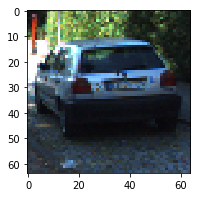

*** Result: CAR ***

HOG visualization for each color channel:


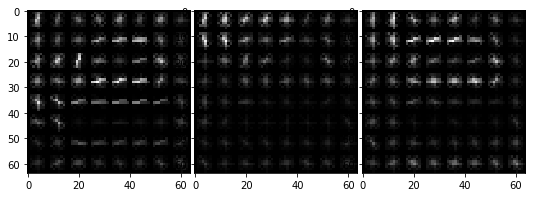

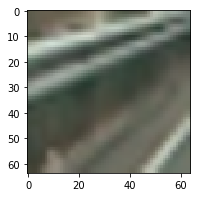

*** Result: NOT CAR ***

HOG visualization for each color channel:


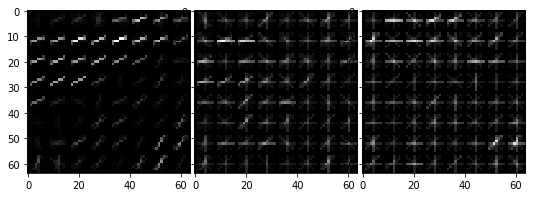

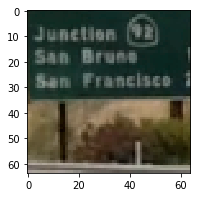

*** Result: NOT CAR ***

HOG visualization for each color channel:


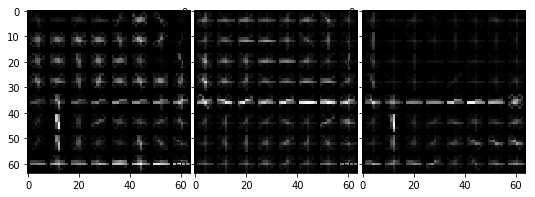

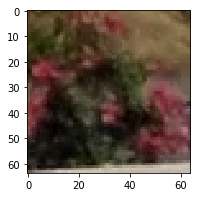

*** Result: NOT CAR ***

HOG visualization for each color channel:


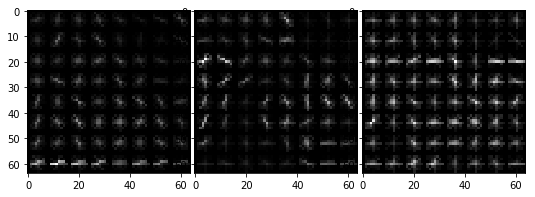

In [15]:
""" Single Image Visualization """

def test_single_image(img_path):
    print('=====================================================================================')
    img = load_image_RGB(img_path)
    plotfig(img, (3,3))
    single_image_detect(img_path, COLOR_SPACE, ORIENT_BINS, PIX_PER_CELL, CELL_PER_BLOCK, HIST_BINS, 
                        SPATIAL_SIZE, X_scaler, svc, hog_feat=HOG_FEAT, hist_feat=HIST_FEAT, 
                        spatial_feat=SPATIAL_FEAT, debug=False)

# Car Image Example
test_single_image('data/vehicles/KITTI_extracted/11.png')

# Not Car Image Example
test_single_image('data/non-vehicles/GTI/image48.png')

# Misdetected Image Example After Hard Negative Retraining
test_single_image('data/non-vehicles/hard_negatives/mined_set01_134.jpg')
test_single_image('data/non-vehicles/hard_negatives/mined_set02_11.jpg')

Analyzing...
1.75 sec/frame, video 37 min = 0.6 hr


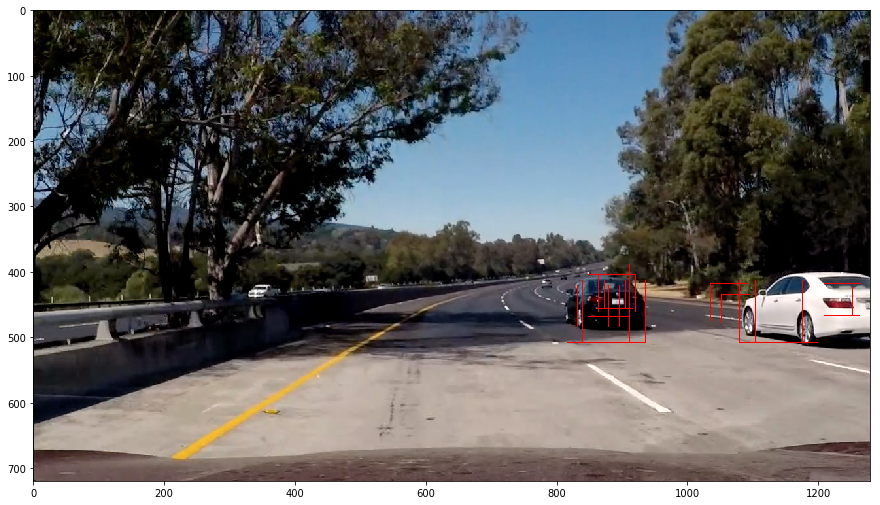

Done.


In [16]:
""" Detect vehicles using pooled subsampling """

image = load_image_RGB('test_images/test5.jpg')

#heat_data.reset()

print('Analyzing...')
t=time.time()
hot_windows = detect_by_pooled_subsampling(image, COLOR_SPACE, ORIENT_BINS, 
                                                   PIX_PER_CELL, CELL_PER_BLOCK,
                                                   HIST_BINS, SPATIAL_SIZE, X_scaler, svc, 
                                                   window_scales_steps_yrange=WINDOW_SETS,
                                                   window_dim=64, hog_feat=HOG_FEAT, 
                                                   hist_feat=HIST_FEAT, spatial_feat=SPATIAL_FEAT,
                                                   debug=True)
t2 = time.time()
print('{:.2f} sec/frame, video {:.0f} min = {:.1f} hr'
      .format(t2-t, (t2-t)*1260/60, (t2-t)*1260/60/60))        

hot_windows = [item for sublist in hot_windows for item in sublist]

raw_detect_img = draw_boxes(image, hot_windows, color=(255, 0, 0), thick=1)

# Save debug results
plotfig(raw_detect_img)
mpimg.imsave('output_images/debug/dbg_raw_detect_img.jpg', raw_detect_img)

print('Done.')

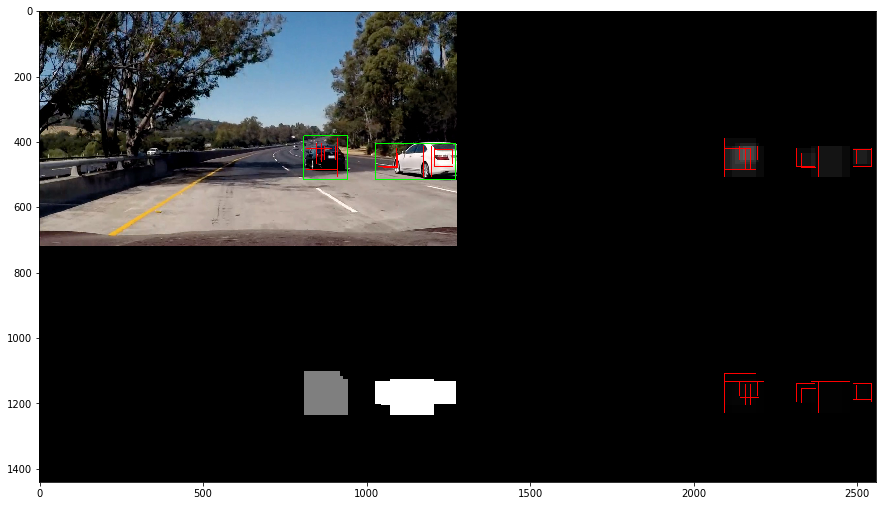

Done.


In [17]:
""" Make heatmaps from detected windows """

# Heat map thresholds for single image testing
HEAT_THRESH = 0 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 0 # Threshold to filter out false positives in combined heatmap

#heat_data.reset()

labels, heat_filtered, combined_heatmap = do_heatmapping(image, hot_windows, 
                                                         heat_thresh=HEAT_THRESH,
                                                         combo_heat_thresh=HEAT_COMBO_THRESH)
label_windows = get_label_windows(labels)

final_detect_img = draw_boxes(image, label_windows, color=(0, 255, 0), thick=2)

# Save debug results
debug_img = make_debug_image(raw_detect_img, hot_windows, heat_filtered, 
                             combined_heatmap, labels, label_windows)

plotfig(debug_img)

mpimg.imsave('output_images/debug/dbg_final_detect_img.jpg', final_detect_img)
mpimg.imsave('output_images/debug/dbg_debug_img.jpg', debug_img)

print('Done.')

In [18]:
""" Vehicle Detection Pipeline Function """

def vehicle_detection_pipeline(image):
    hot_windows = detect_by_pooled_subsampling(image, COLOR_SPACE, ORIENT_BINS, 
                                               PIX_PER_CELL, CELL_PER_BLOCK, HIST_BINS,
                                               SPATIAL_SIZE, X_scaler, svc,
                                               window_scales_steps_yrange=WINDOW_SETS,
                                               window_dim=64, hog_feat=HOG_FEAT,
                                               hist_feat=HIST_FEAT,
                                               spatial_feat=SPATIAL_FEAT,
                                               debug=False)

    hot_windows = [item for sublist in hot_windows for item in sublist]
    
    raw_detect_img = draw_boxes(image, hot_windows, color=(255, 0, 0), thick=1)
    
    labels, heat_filtered, combined_heatmap = do_heatmapping(image, hot_windows,
                                                             heat_thresh=HEAT_THRESH,
                                                             combo_heat_thresh=HEAT_COMBO_THRESH)
    label_windows = get_label_windows(labels)
    
    final_detect_img = draw_boxes(image, label_windows, color=(0, 255, 0), thick=2)
    
    if DEBUG_MODE == 1:
        final_detect_img = make_debug_image(raw_detect_img, hot_windows, heat_filtered,
                                            combined_heatmap, labels, label_windows)
    
    return final_detect_img

print('Done.')

Done.




test1.jpg  without detected vehicles


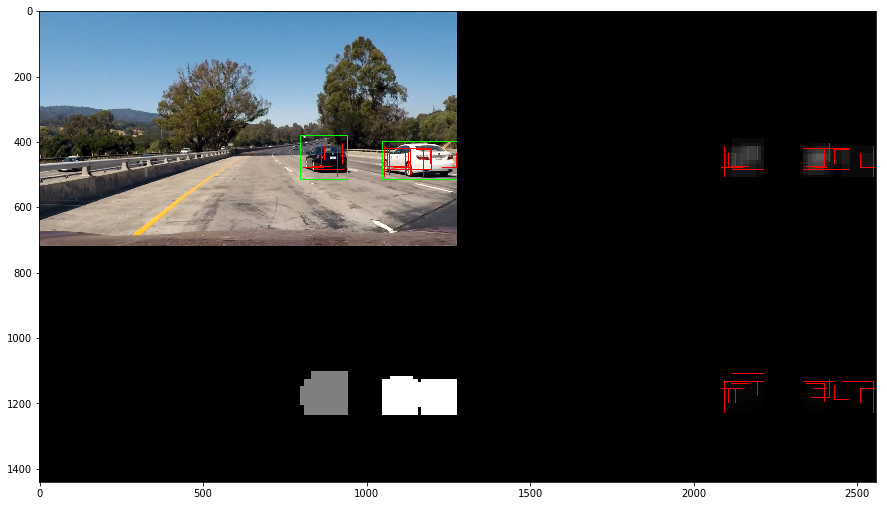

test1.jpg  with detected vehicles


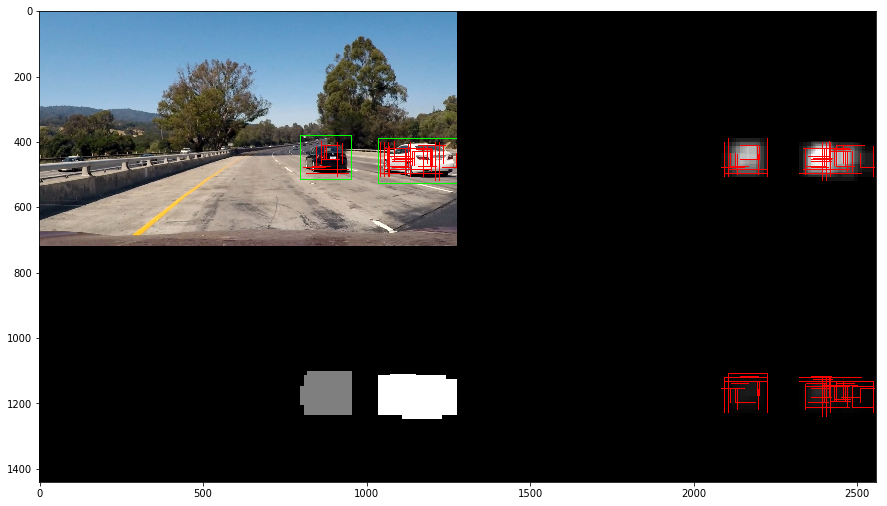



test2.jpg  without detected vehicles


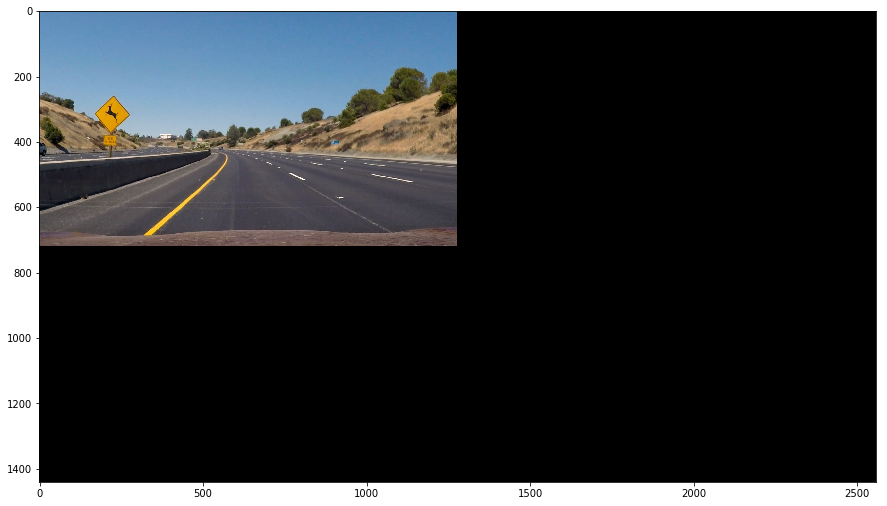

test2.jpg  with detected vehicles


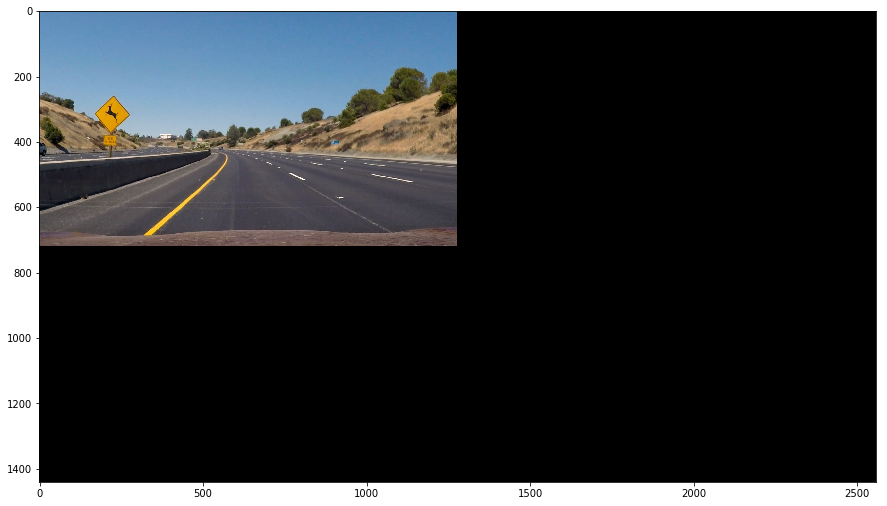



test3.jpg  without detected vehicles


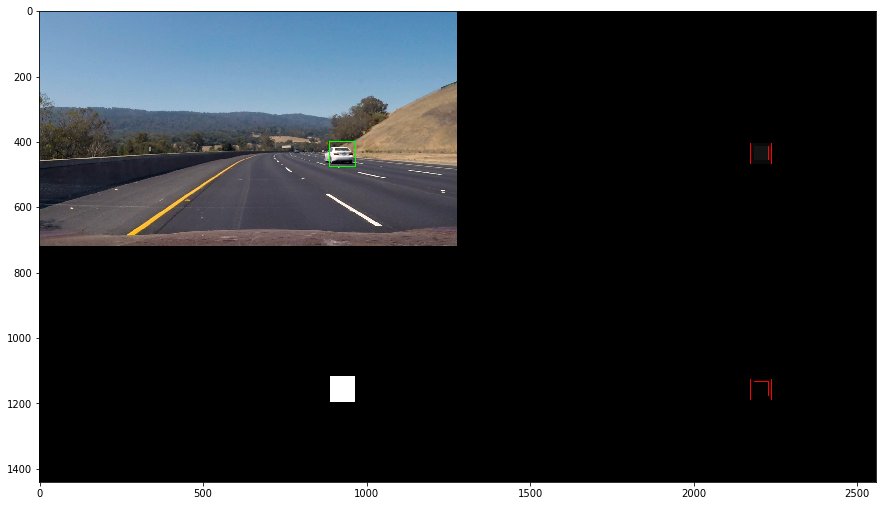

test3.jpg  with detected vehicles


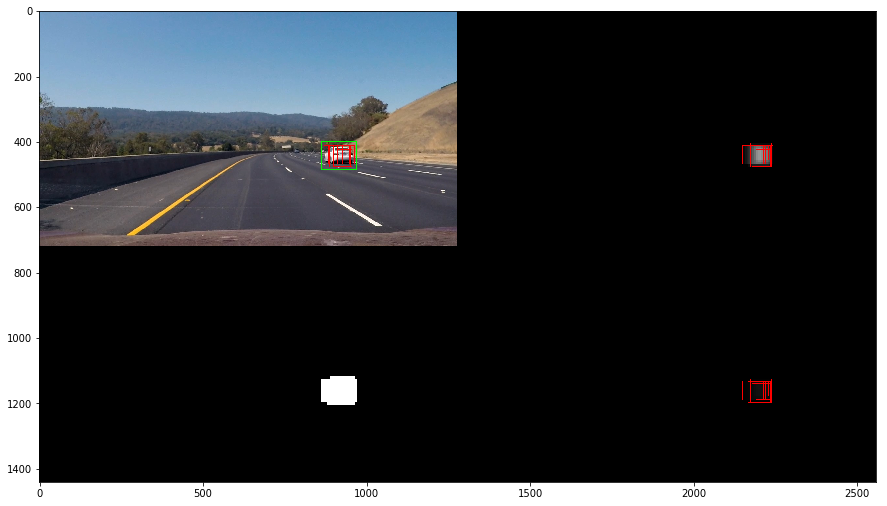



test4.jpg  without detected vehicles


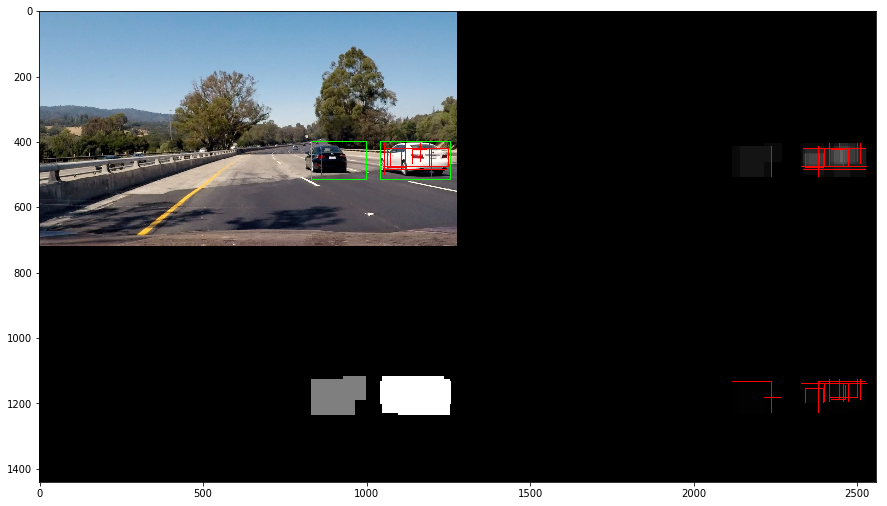

test4.jpg  with detected vehicles


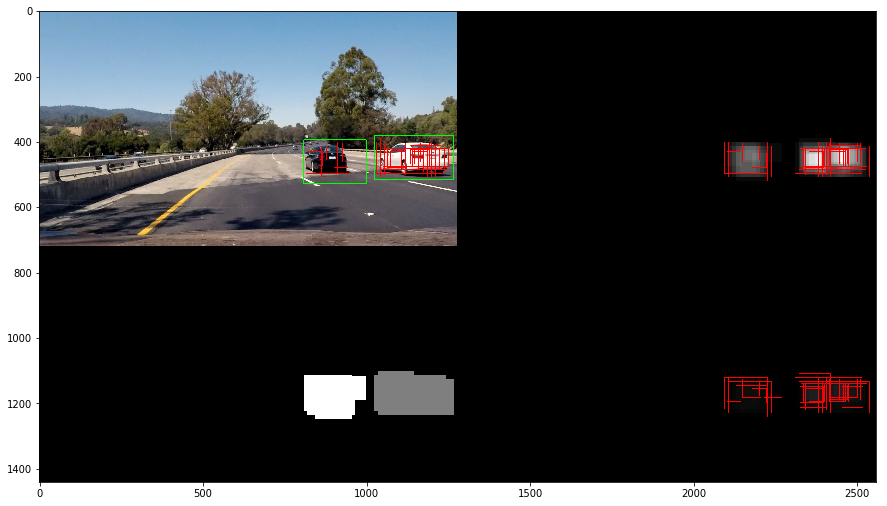



test5.jpg  without detected vehicles


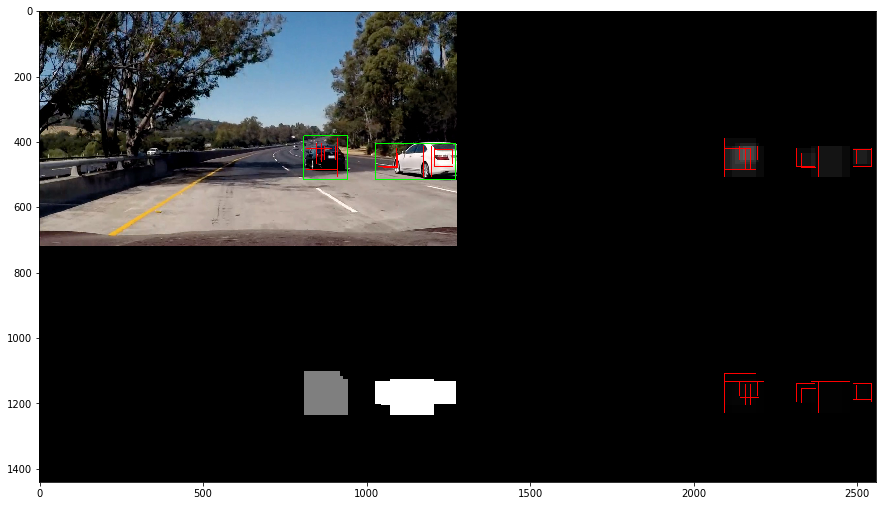

test5.jpg  with detected vehicles


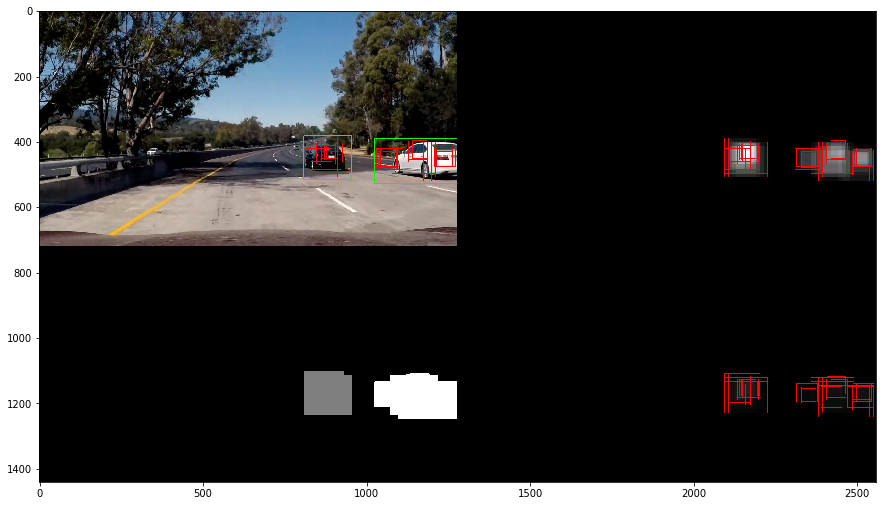



test6.jpg  without detected vehicles


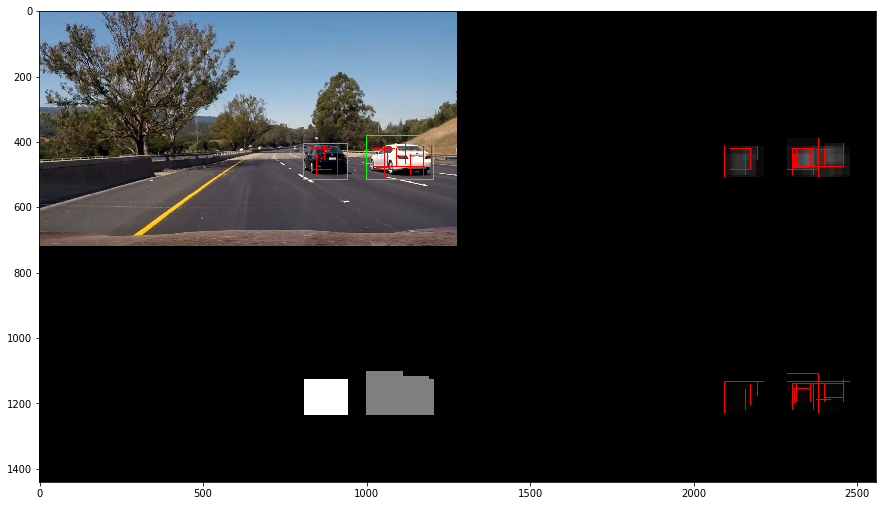

test6.jpg  with detected vehicles


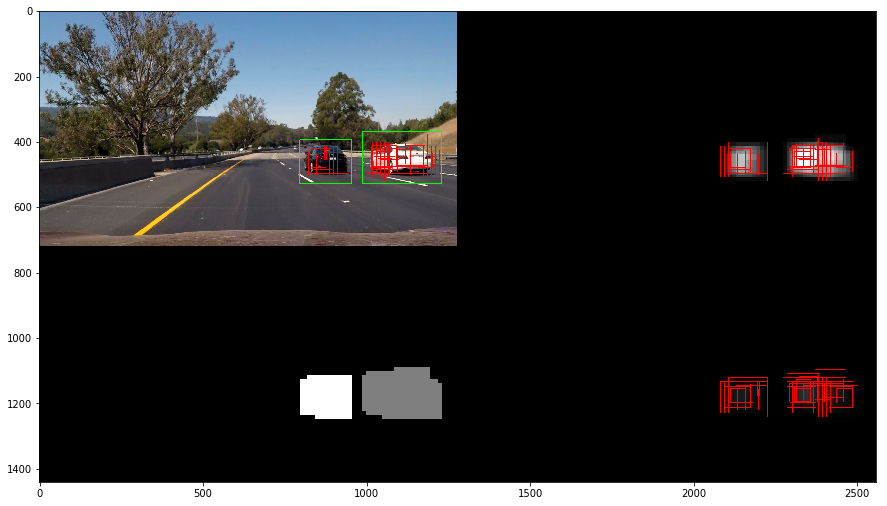



test_ex01.jpg  without detected vehicles


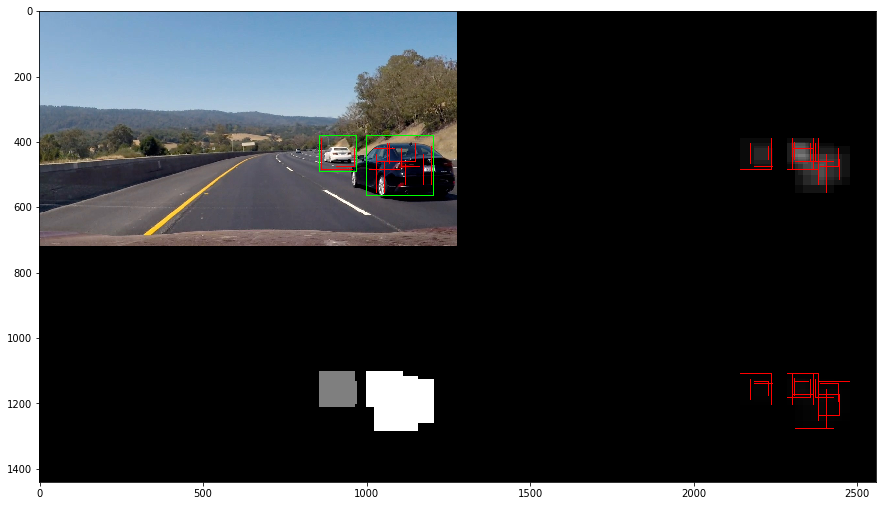

test_ex01.jpg  with detected vehicles


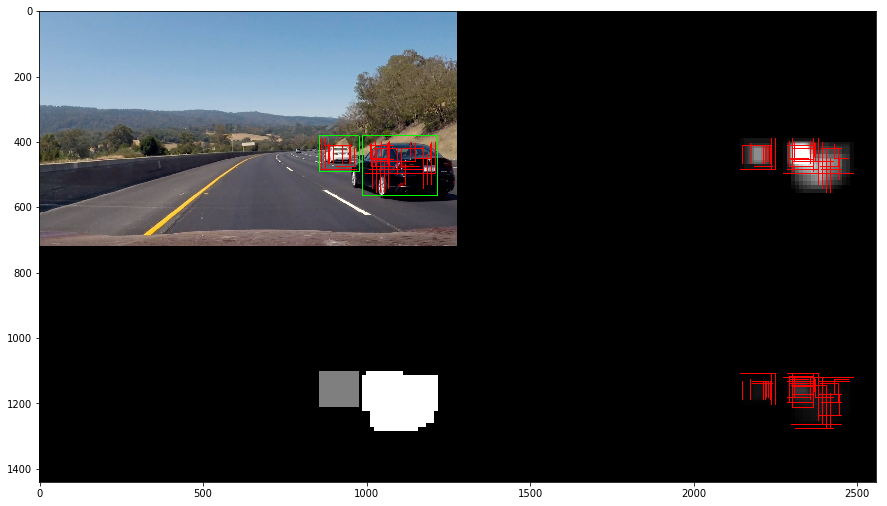



test_ex02.jpg  without detected vehicles


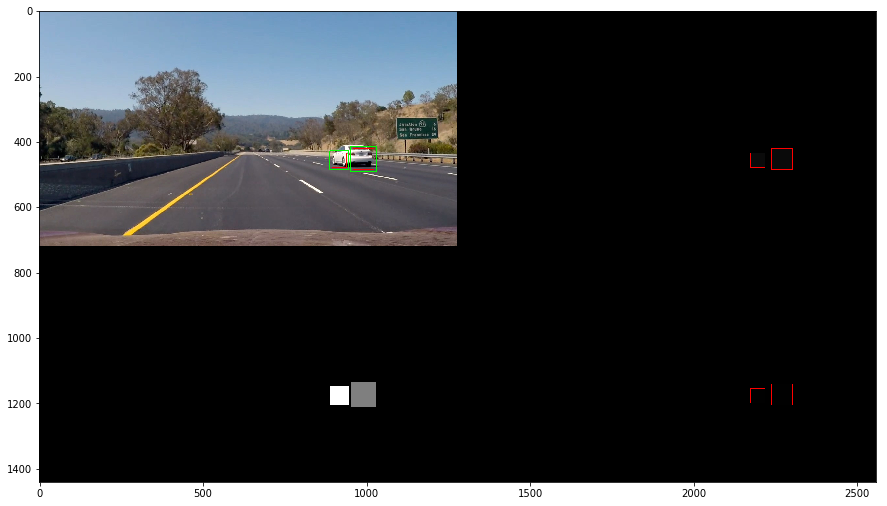

test_ex02.jpg  with detected vehicles


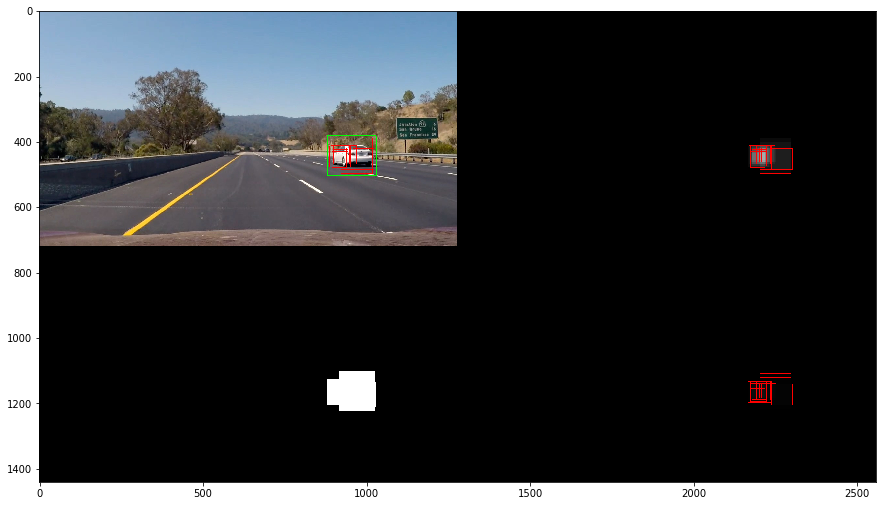



test_ex03.jpg  without detected vehicles


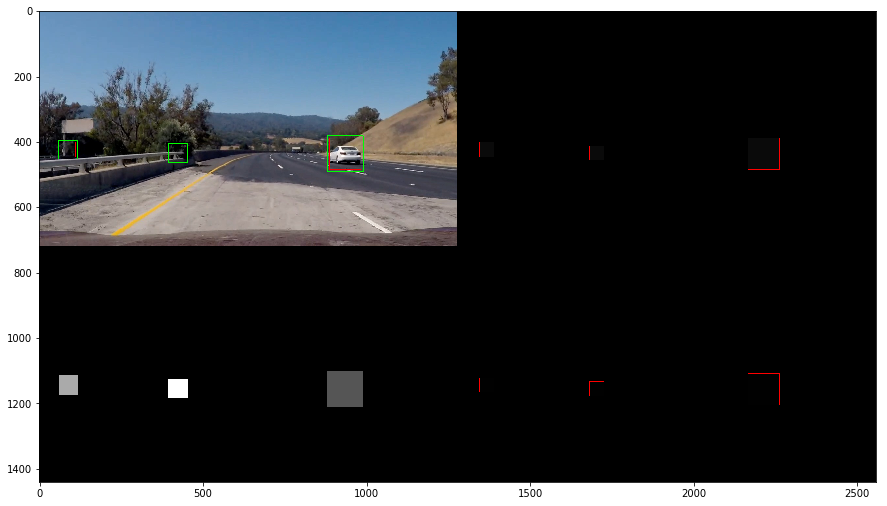

test_ex03.jpg  with detected vehicles


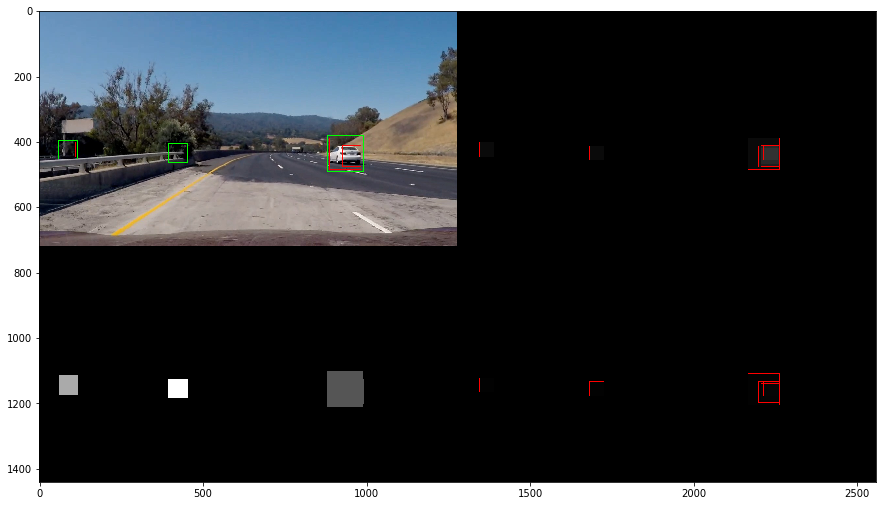

Done.


In [19]:
""" Single image testing (before/after car detection) """

# Heat map thresholds for single image testing
HEAT_THRESH = 0 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 0 # Threshold to filter out false positives in combined heatmap

def single_image_test(file_dir, file_name):
    print('\n===============================================================================================\n')
    output_dir = 'output_images/'
    image = load_image_RGB(file_dir+file_name)
    heat_data.reset()
    result = vehicle_detection_pipeline(image)
    print(file_name, ' without detected vehicles')
    plotfig(result)
    mpimg.imsave(output_dir+'dbg_'+file_name[:-4]+'_A.jpg', result)
    result = vehicle_detection_pipeline(image)
    print(file_name, ' with detected vehicles')
    plotfig(result)
    mpimg.imsave(output_dir+'dbg_'+file_name[:-4]+'_B.jpg', result)

# Test each single example image
single_image_test('test_images/', 'test1.jpg')
single_image_test('test_images/', 'test2.jpg')
single_image_test('test_images/', 'test3.jpg')
single_image_test('test_images/', 'test4.jpg')
single_image_test('test_images/', 'test5.jpg')
single_image_test('test_images/', 'test6.jpg')
single_image_test('test_images/', 'test_ex01.jpg')
single_image_test('test_images/', 'test_ex02.jpg')
single_image_test('test_images/', 'test_ex03.jpg')

print('Done.')

## Video Processing

In [20]:
""" Short test video """

OUTPUT_VIDEO1 = 1

# Heat map thresholds for video processing
HEAT_THRESH = 2 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 60 # Threshold to filter out false positives in combined heatmap

if OUTPUT_VIDEO1 == 1:
    heat_data.reset()
    clip1_output = 'output_images/test_video.mp4'
    clip1 = VideoFileClip('test_video.mp4')
    clip1_out = clip1.fl_image(vehicle_detection_pipeline)
    clip1_out.write_videofile(clip1_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [00:53<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 



In [21]:
""" Subclip of project video for hard negative mining """

OUTPUT_VIDEO2 = 1

# Heat map thresholds for video processing
HEAT_THRESH = 2 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 60 # Threshold to filter out false positives in combined heatmap

#miner.start('mined_set03')

if OUTPUT_VIDEO2 == 1:
    heat_data.reset()
    clip1_output = 'output_images/project_video_subclip.mp4'
    clip1 = VideoFileClip('project_video.mp4').subclip(18,20)
    clip1_out = clip1.fl_image(vehicle_detection_pipeline)
    clip1_out.write_videofile(clip1_output, audio=False)
    
miner.reset()

[MoviePy] >>>> Building video output_images/project_video_subclip.mp4
[MoviePy] Writing video output_images/project_video_subclip.mp4


 98%|█████████▊| 50/51 [00:58<00:01,  1.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_subclip.mp4 



In [22]:
""" Full project video """

OUTPUT_VIDEO3 = 0

DEBUG_MODE = 0 # Option to output debug images

# Heat map thresholds for video processing
HEAT_THRESH = 2 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 60 # Threshold to filter out false positives in combined heatmap

if OUTPUT_VIDEO3 == 1:
    heat_data.reset()
    clip1_output = 'output_images/project_video_output.mp4'
    clip1 = VideoFileClip('project_video.mp4')
    clip1_out = clip1.fl_image(vehicle_detection_pipeline)
    clip1_out.write_videofile(clip1_output, audio=False)

## Advanced Lane Finding Pipeline from Project #4

In [23]:
""" Advanced lane detection code from previous Project #4 """
""" https://github.com/edufford/CarND-Advanced-Lane-Lines-P4 """

# Line class to store the characteristics of each detected lane line
class Line():
    def reset(self):
        self.N_FITS = 5 # number of fits to combine for smoothing 
        self.detected = False # valid lane detection flag
        self.valid_reason = '' # reason for valid lane judgement
        self.current_x = [[]] # x coordinates of detected lane points in current frame
        self.current_y = [[]] # y coordinates of detected lane points in current frame
        self.all_x = [[]] # x coordinates of detected lane points in combined frames
        self.all_y = [[]] # y coordinates of detected lane points in combined frames
        self.current_fit = np.array([0, 0, 0]) # 2nd order polyfit coefficients for current x,y points
        self.all_fit = np.array([0, 0, 0]) # 2nd order polyfit coefficients for combined x,y points
        self.radius_of_curvature = 0.0 # calculated radius of curvature of line
        self.line_base_pos = 0.0 # calculated offset distance from line to center of car
        
    def __init__(self):
        self.reset()
        
def reset_lanes():
    left_lane.reset()
    right_lane.reset()

# Define conversions in x and y from pixels space to meters based on US standards
US_LANE_WIDTH = 3.7 # m wide lane
US_LANE_LINE_LENGTH = 3.0 # m long lines
LANE_WIDTH_PIX = 675 # (980-305) pixels
LANE_LINE_LENGTH_PIX = 83 # (533-450) pixels

ym_per_pix = US_LANE_LINE_LENGTH/LANE_LINE_LENGTH_PIX # meters per pixel in y dimension = 0.036145
xm_per_pix = US_LANE_WIDTH/LANE_WIDTH_PIX # meters per pixel in x dimension = 0.005481

left_lane = Line()
right_lane = Line()
print('Lane line objects created.')

# Load camera calibration coefficients from pickle file
dist_pickle = pickle.load(open('camera_cal/camera_mtx_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
print('Loaded distortion coefficients [k1, k2, p1, p2, k3]:\n{}\n'.format(dist))

def camera_undistort(img, mtx, dist, debug=False):
    """
    Undistort image using camera calibration coefficients (mtx, dist)
    """
    img_out = cv2.undistort(img, mtx, dist, None, mtx)
    
    if debug == True:
        print('Undistorting image...\n')
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(img_out)
        ax2.set_title('Undistorted Image', fontsize=20)
        plt.show()
        
    return img_out

def apply_CLAHE_LAB(img, debug=False):
    """
    Convert image from RGB->LAB and apply CLAHE contrast-limited adaptive histogram equalization
    to the lightness channel to help normalize the images for visual processing.
    
    This function returns the CLAHE normalized image.
    """
    image_wk = np.copy(img)
    image_wk = cv2.cvtColor(image_wk, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
    image_wk[:,:,0] = clahe.apply(image_wk[:,:,0])
    image_wk = cv2.cvtColor(image_wk, cv2.COLOR_LAB2RGB)
    
    if debug == True:
        print('Before CLAHE')
        plt.figure(figsize = (15,8))
        plt.imshow(img)
        plt.show()
        
        print('After CLAHE')
        plt.figure(figsize = (15,8))
        plt.imshow(image_wk)
        plt.show()
        
    return image_wk

def do_perspective_transform(img, M, debug=False):
    """
    Warp image using perspective transform matrix M and cv2.warpPerspective() with linear interpolation.
    
    This function returns the warped image.
    """
    img_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    if debug == True:
        plt.figure(figsize = (15, 10))
        plt.imshow(img_warped, cmap='gray')
        plt.show()

    return img_warped

def set_perspective_transform(img, video=0, debug=False):
    """
    Set perspective transform matrices M & Minv using fixed source/destination points picked
    from a straight lane road image.
    
    This function returns the transformation matrices M and Minv.
    """
    img_PTin = np.copy(img)
    img_size = (img_PTin.shape[1], img_PTin.shape[0])
    y_car = img_PTin.shape[0]
        
    if video == 0:
        # Original perspective TRAPEZOID points for PROJECT VIDEO
        XL_CAR = 205
        XR_CAR = 1105
        XL_VANISH = 595
        XR_VANISH = 685
        Y_VANISH = 450
        
    elif video == 1:
        # Original perspective TRAPEZOID points for CHALLENGE VIDEO
        XL_CAR = 295
        XR_CAR = 1130
        XL_VANISH = 600
        XR_VANISH = 720
        Y_VANISH = 480
        
    elif video == 2:
       # Original perspective TRAPEZOID points for HARDER CHALLENGE VIDEO
        XL_CAR = 255
        XR_CAR = 1105
        XL_VANISH = 585
        XR_VANISH = 755
        Y_VANISH = 470
        
    # Transformed perspective RECTANGLE points
    XL_CAR_PT = 300
    XR_CAR_PT = 980
    Y_VANISH_PT = 0
 
    # TRAPEZOID vertices
    trap_bl = [XL_CAR, y_car]
    trap_tl = [XL_VANISH, Y_VANISH]
    trap_tr = [XR_VANISH, Y_VANISH]
    trap_br = [XR_CAR, y_car]
    trap_vertices = np.array([[trap_bl, trap_tl, trap_tr, trap_br]], dtype=np.int32)

    # RECTANGLE vertices
    rect_bl = [XL_CAR_PT, y_car]
    rect_tl = [XL_CAR_PT, Y_VANISH_PT]
    rect_tr = [XR_CAR_PT, Y_VANISH_PT]
    rect_br = [XR_CAR_PT, y_car]
    rect_vertices = np.array([[rect_bl, rect_tl, rect_tr, rect_br]], dtype=np.int32)

    # Source = TRAPEZOID, Destination = RECTANGLE
    src = np.float32([trap_bl, trap_tl, trap_tr, trap_br])
    dst = np.float32([rect_bl, rect_tl, rect_tr, rect_br])

    # Set perspective transform matrices
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if debug == True:
        print('Before perspective transform (source trapezoid vertices)')
        cv2.polylines(img_PTin, trap_vertices, True, (255, 0, 0))
        plt.figure(figsize = (15, 10))
        plt.imshow(img_PTin)
        plt.show()
        
        print('After perspective transform (destination rectangle vertices)')
        img_warped = do_perspective_transform(img_PTin, M)
        image_wk = np.copy(img_warped)
        cv2.polylines(image_wk, rect_vertices, True, (255, 0, 0))
        plt.figure(figsize = (15, 10))
        plt.grid()
        plt.imshow(image_wk)
        plt.show()

    return M, Minv

VIDEO_SWITCH = 0
# 0 = Project video
# 1 = Challenge video
# 2 = Harder challenge video

""" Pipeline Step 4: Color threshold binary image """

def color_binary_thresh(img, debug=False):
    """
    Convert image to LAB color space and make binary images for yellow and white color detection.
    Combine yellow and white binary images and blur to expand detected region for masking with
    gradient binary image.
    
    This function returns the binary image of blurred Yellow+White color filter.
    """
    img_CBTin = np.copy(img)
    
    def color_select(img, val, thresh=(0, 255)):
        channel = img[:,:,val]
        binary_output = np.zeros_like(channel)
        binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
        return binary_output

    img_LAB = cv2.cvtColor(img_CBTin, cv2.COLOR_RGB2LAB)
    
    # Make YELLOW binary image
    binary_yellow_L = color_select(img_LAB, 0, thresh=(130, 255))
    binary_yellow_A = color_select(img_LAB, 1, thresh=(100, 150))
    binary_yellow_B = color_select(img_LAB, 2, thresh=(145, 210))
    
    binary_yellow = np.zeros_like(binary_yellow_L)
    binary_yellow[(binary_yellow_L == 1) & (binary_yellow_A == 1) & (binary_yellow_B == 1)] = 1
    
    # Make WHITE binary image
    binary_white_L = color_select(img_LAB, 0, thresh=(230, 255))
    binary_white_A = color_select(img_LAB, 1, thresh=(120, 140))
    binary_white_B = color_select(img_LAB, 2, thresh=(120, 140))
    
    binary_white = np.zeros_like(binary_white_L)
    binary_white[(binary_white_L == 1) & (binary_white_A == 1) & (binary_white_B == 1)] = 1
    
    # Combine YELLOW and WHITE binary images
    binary_color = np.zeros_like(binary_yellow)
    binary_color[(binary_yellow == 1) | (binary_white == 1)] = 1
    
    # Blur binary image to expand for masking
    binary_color_float = binary_color.astype(np.float)
    binary_color_float = cv2.blur(binary_color_float, (3, 3))
    binary_color_blur = np.zeros_like(binary_color)
    binary_color_blur[ (binary_color_float > 0.0) ] = 1
    
    if debug == True:
        print('LAB Color Space')
        plt.figure(figsize = (15, 10))
        plt.imshow(img_LAB)
        plt.show()
        
        print('Yellow Binary')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_yellow, cmap='gray')
        plt.show()
        
        print('White Binary')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_white, cmap='gray')
        plt.show()
        
        print('Yellow + White Binary')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_color, cmap='gray')
        plt.show()
        
        print('Blur Yellow + White Binary')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_color_blur, cmap='gray')
        plt.show()

    return binary_color_blur

""" Pipeline Step 5: Gradient threshold binary image """

def sobel_denoise(binary_img, kernel=5, thresh=0.7, debug=False):
    """
    Custom binary denoise function to filter out small pixel grain noise in sobel gradients
    without blobbing points together like cv2.fastNlMeansDenoising() does.
    
    This function returns the denoised binary image.
    """
    binary_float = binary_img.astype(np.float)
    binary_float = cv2.blur(binary_float, (kernel, kernel))
    binary_denoise = np.zeros_like(binary_img)
    binary_denoise[ (binary_float > thresh) ] = 1
    
    if debug == True:
        print('Denoise')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_denoise, cmap='gray')
        plt.show()

    return binary_denoise
    
def sobel_x_thresh(img, sobel_kernel=3, thresh=(0, 255), debug=False):
    """
    Make binary image of sobel gradient along X-axis.
    
    This function returns the binary image of gradient by X-axis.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobel = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    if debug == True:
        print('Gradient along X-axis')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_output, cmap='gray')
        plt.show()
    
    return binary_output

def sobel_mag_thresh(img, sobel_kernel=3, thresh=(0, 255), debug=False):
    """
    Make binary image of sobel gradient based on magnitude thresholds.
    
    This function returns the binary image of gradient by Magnitude.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
        
    if debug == True:               
        print('Gradient by Magnitude')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_output, cmap='gray')
        plt.show()
        
    return binary_output

def sobel_dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2), debug=False):
    """
    Make binary image of sobel gradient based on direction thresholds.
    
    This function returns the binary image of gradient by Direction.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir, dtype=np.uint8)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    if debug == True: 
        print('Gradient by Direction')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_output, cmap='gray')
        plt.show()
    
    return binary_output

def sobel_magdir_combine(binary_mag, binary_dir, debug=False):
    """
    Combine Magnitude gradient with Direction gradient by simple AND condition.
    
    This function returns the binary image of gradient by Magnitude+Direction.
    """
    binary_output = np.zeros_like(binary_mag)
    binary_output[(binary_mag == 1) & (binary_dir == 1)] = 1
    
    if debug == True:
        print('Gradient by Combined Magnitude + Direction')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_output, cmap='gray')
        plt.show()
        
    return binary_output

def grad_combo_binary_thresh(img_gradx, img_magdir, debug=False):
    """
    Combine warped X-axis gradient with Magnitude+Direction gradient by simple OR condition.
    
    This function returns the binary image of combined gradient by X-axis and Magnitude+Direction.
    """
    binary_gradient = np.zeros_like(img_gradx)
    binary_gradient[ (img_gradx == 1) | (img_magdir == 1) ] = 1
  
    if debug == True:
        print('Combined Gradient Binary')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_gradient, cmap='gray')
        plt.show()
    
    return binary_gradient

""" Pipeline Step 6: Combine threshold binary images """

def combine_color_gradient_threshold(binary_color, binary_gradient, debug=False):
    """
    Make final binary image by combining color and gradient binary images.
    
    If lanes are not detected, use both color AND gradient binaries for more restrictive 
    selection of lane pixels.  This minimizes misdetection from noise and interference
    by cracks, shadows, etc in the road.
    
    If lanes are already detected, use only color binary for more broad selection since the
    search is already limited to a window around the known lane location.  This allows more
    lane pixels to get a better polyfit and extend the detected lane further down the road.
    
    This function returns the final warped binary image to use for lane detection.
    """
    
    if (left_lane.detected == True) and (right_lane.detected == True):
        binary_final = binary_color
    else:
        binary_final = cv2.bitwise_and(binary_color, binary_gradient)
    
    if debug == True:
        print('Combine color + gradient')
        plt.figure(figsize = (15, 10))
        plt.imshow(binary_final, cmap='gray')
        plt.show()

    return binary_final

""" Pipeline Step 7: Lane detection and validity judgement """

def search_for_new_lanes(binary_warped, debug=False):
    """
    Search for new lanes in the warped binary image by using sliding windows of 
    width NEW_WINDOW_MARGIN_M and vertically split into N_WINDOWS.
    Start the bottom windows centered at initial x positions found by two max peaks in vertical 
    slice histograms of the bottom 1/4 (or 1/2 if no points were found) of the binary image.
    Use the mean x position of the points within the window to set the center of the next window up.
    If not enough points are found on one side, but the other side has points, set the window center
    based on the previous detected lane width between left/right windows.
    If not enough points are found on either side, continue to slide the window centers by momentum
    calculated by the previous window lateral movements.
    Narrow the window to width NEW_LANE_MARGIN_M to set the final lane x, y points to reduce noise.
    
    This function stores the detected lane x,y values and polyfits in the lane objects:
        left_lane.current_x
        left_lane.current_y
        right_lane.current_x
        right_lane.current_y
        left_lane.current_fit
        right_lane.current_fit
    """
    # Tuning parameters
    N_WINDOWS = 8
    FOUND_MIN_PIX = 50 # pix
    HIST_PEAK_MARGIN_M = 2.2 # (m) minimum separation in detected histogram peaks
    NEW_WINDOW_MARGIN_M = 0.5 # (m) search window width for sliding windows
    NEW_LANE_MARGIN_M = 0.2 # (m) search window width for final point detection
    
    # Initialize
    left_lane_xpts = []
    left_lane_ypts = []
    right_lane_xpts = []
    right_lane_ypts = []
    hist_peak_margin = np.int(HIST_PEAK_MARGIN_M / xm_per_pix)
    window_margin = np.int(NEW_WINDOW_MARGIN_M / xm_per_pix)
    lane_margin = np.int(NEW_LANE_MARGIN_M / xm_per_pix)
    
    # Create an output image to draw sliding windows on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    ### Vertical Sum Histograms ###
    
    # First try taking histogram of bottom 1/4 of image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4*3:,:], axis=0)
    if np.sum(histogram) == 0:
        # if no pix were found, retake histogram of bottom 1/2 of image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    ### Histogram Peak Detection ###
    
    # Look for two peaks in histogram to start searching for left/right lanes
    first_peak_x = np.argmax(histogram)
    look_right_x = min(first_peak_x + hist_peak_margin, binary_warped.shape[1]-1)
    look_left_x = max(first_peak_x - hist_peak_margin, 1)
    right_of_first_peak = max(histogram[look_right_x:])
    left_of_first_peak = max(histogram[:look_left_x])
    if right_of_first_peak > left_of_first_peak:
        # Found second peak to the right of first peak
        win_center_leftx_base = first_peak_x
        win_center_rightx_base = np.argmax(histogram[look_right_x:]) + look_right_x
    else:
        # Found second peak to the left of first peak
        win_center_rightx_base = first_peak_x
        win_center_leftx_base = np.argmax(histogram[:look_left_x])

    # Set height of windows
    win_height = np.int(binary_warped.shape[0]/N_WINDOWS)

    ### Sliding Window Search ###
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Initial values for window momentum
    win_leftx_momentum = 0
    win_rightx_momentum = 0
    win_center_leftx_current = win_center_leftx_base
    win_center_rightx_current = win_center_rightx_base

    # Initial value for detected lane width
    current_lane_width = win_center_rightx_current - win_center_leftx_current

    # Step through the windows one by one
    for n_window in range(N_WINDOWS):
        win_center_leftx_prev = win_center_leftx_current # store for window momentum
        win_center_rightx_prev = win_center_rightx_current

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (n_window+1)*win_height
        win_y_high = binary_warped.shape[0] - n_window*win_height
        win_xleft_low = win_center_leftx_current - window_margin
        win_xleft_high = win_center_leftx_current + window_margin
        win_xright_low = win_center_rightx_current - window_margin
        win_xright_high = win_center_rightx_current + window_margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                        & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                        & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        num_left = len(good_left_inds)
        num_right = len(good_right_inds)

        # Update search window centers
        if (num_left > FOUND_MIN_PIX) and (num_right > FOUND_MIN_PIX):
            # Left OK, Right OK -> set window centers by mean x positions
            win_center_leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            win_center_rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            current_lane_width = win_center_rightx_current - win_center_leftx_current
        elif (num_left < FOUND_MIN_PIX) and (num_right > FOUND_MIN_PIX):
            # Left NG, Right OK -> set Left window center by lane width
            win_center_rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            win_center_leftx_current = win_center_rightx_current - current_lane_width
        elif (num_left > FOUND_MIN_PIX) and (num_right < FOUND_MIN_PIX):
            # Left OK, Right NG -> set Right window center by lane width
            win_center_leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            win_center_rightx_current = win_center_leftx_current + current_lane_width
        elif (num_left < FOUND_MIN_PIX) and (num_right < FOUND_MIN_PIX):
            # Left NG, Right NG -> set Left and Right window centers by momentum
            win_center_leftx_current = win_center_leftx_prev + win_leftx_momentum
            win_center_rightx_current = win_center_rightx_prev + win_rightx_momentum

        # Update window momentum
        win_leftx_momentum = (win_center_leftx_current - win_center_leftx_prev)
        win_rightx_momentum = (win_center_rightx_current - win_center_rightx_prev)

        # Narrow window for actual final x,y point selection
        win_xleft_low = win_center_leftx_current - lane_margin
        win_xleft_high = win_center_leftx_current + lane_margin
        win_xright_low = win_center_rightx_current - lane_margin
        win_xright_high = win_center_rightx_current + lane_margin
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (255,0,255), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (255,0,255), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                        & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                        & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these x,y values to the lists
        left_lane_xpts.append(nonzerox[good_left_inds])
        left_lane_ypts.append(nonzeroy[good_left_inds])
        right_lane_xpts.append(nonzerox[good_right_inds])
        right_lane_ypts.append(nonzeroy[good_right_inds])

    # After searching all windows, concatenate and store detected x,y points
    left_lane.current_x = np.concatenate(left_lane_xpts)
    left_lane.current_y = np.concatenate(left_lane_ypts)
    right_lane.current_x = np.concatenate(right_lane_xpts)
    right_lane.current_y = np.concatenate(right_lane_ypts)
    
    # Polyfit detected points
    if (len(left_lane.current_x) > 0) and (len(left_lane.current_x) == len(left_lane.current_y)):
        left_lane.current_fit = np.polyfit(left_lane.current_y, left_lane.current_x, 2)
    if (len(right_lane.current_x) > 0) and (len(right_lane.current_x) == len(right_lane.current_y)):
        right_lane.current_fit = np.polyfit(right_lane.current_y, right_lane.current_x, 2)
    
    if debug == True:
        print('Histogram search for lane peaks')
        plt.imshow(binary_warped, cmap='gray')
        plt.show()        
        plt.plot(histogram)
        plt.show()

        print('Search by sliding windows')
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = (left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2])
        right_fitx = (right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2])
        out_img[left_lane.current_y, left_lane.current_x] = [255, 0, 0]
        out_img[right_lane.current_y, right_lane.current_x] = [0, 0, 255]
        plt.figure(figsize = (15, 10))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
def search_for_existing_lanes(binary_warped, debug=False):
    """
    Search for lanes around existing detected lane line polyfits with margin DETECTED_LANE_WINDOW_MARGIN.
    
    This function stores the detected lane x,y values and polyfits in the lane objects:
        left_lane.current_x
        left_lane.current_y
        right_lane.current_x
        right_lane.current_y
        left_lane.current_fit
        right_lane.current_fit
    """
    # Tuning parameters
    DETECTED_LANE_WINDOW_MARGIN = 0.3 # (m)
    
    # Get current lane fits
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    margin = np.int(DETECTED_LANE_WINDOW_MARGIN / xm_per_pix)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                    & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                     & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    left_lane.current_x = nonzerox[left_lane_inds]
    left_lane.current_y = nonzeroy[left_lane_inds] 
    right_lane.current_x = nonzerox[right_lane_inds]
    right_lane.current_y = nonzeroy[right_lane_inds]

    # Polyfit detected points
    if (len(left_lane.current_x) > 0) and (len(left_lane.current_x) == len(left_lane.current_y)):
        left_lane.current_fit = np.polyfit(left_lane.current_y, left_lane.current_x, 2)
    if (len(right_lane.current_x) > 0) and (len(right_lane.current_x) == len(right_lane.current_y)):
        right_lane.current_fit = np.polyfit(right_lane.current_y, right_lane.current_x, 2) 

    if debug == True:
        # Make images for plotting
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        # Plot current lane fit curves
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = (left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
        right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
        
        # Color in left and right line pixels
        out_img[left_lane.current_y, left_lane.current_x] = [255, 0, 0]
        out_img[right_lane.current_y, right_lane.current_x] = [0, 0, 255]
        
        # Generate a polygon to illustrate the search window area around the lane fit curves
        # and recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        
        # Combine lane fit curves, lane points, and search window area
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        print('Search by current lane fit curves')
        plt.figure(figsize = (15, 10))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.show()

def lane_validity_check(binary_warped, debug=False):
    """
    Judge if detected lane is valid based on min/max lane width and number of detected lane line pixels.
    
    This function stores the lane detection judgement flag in the lane objects:
        left_lane.detected
        right_lane.detected
    """
    # Tuning parameters
    LANE_DETECT_MIN_PIX = 50 # pix
    LANE_DETECT_MAX_PIX = 70000 # pix
    LANE_WIDTH_MIN_M = 1.0 # m
    LANE_WIDTH_MAX_M = 6.0 # m

    # Initialize
    left_lane.valid_reason = 'OK'
    right_lane.valid_reason = 'OK'
    left_ok = True
    right_ok = True
    min_lane_width = 0
    max_lane_width = 0
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    left_x_num = len(left_lane.current_x)
    left_y_num = len(left_lane.current_y)
    right_x_num = len(right_lane.current_x)
    right_y_num = len(right_lane.current_y)
    lane_width_min_pix = np.int(LANE_WIDTH_MIN_M / xm_per_pix)
    lane_width_max_pix = np.int(LANE_WIDTH_MAX_M / xm_per_pix)

    # Calculate max/min lane widths
    y_eval = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    rightx_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    min_lane_width = min(rightx_eval - leftx_eval)
    max_lane_width = max(rightx_eval - leftx_eval)
    
    # Judge if lanes are reasonable by lane width
    if min_lane_width < lane_width_min_pix:
        left_ok = False
        right_ok = False
        left_lane.valid_reason = 'Lane too narrow'
        right_lane.valid_reason = left_lane.valid_reason

    if max_lane_width > lane_width_max_pix:
        left_ok = False
        right_ok = False
        left_lane.valid_reason = 'Lane too wide'
        right_lane.valid_reason = left_lane.valid_reason
     
    # Judge if lanes are reasonable by number of detected pixels
    if ((left_x_num != left_y_num)
        or (left_x_num < LANE_DETECT_MIN_PIX) 
        or (left_x_num > LANE_DETECT_MAX_PIX)):
        left_ok = False
        right_ok = False
        left_lane.valid_reason = 'Number of Lane Pixels'
        
    if ((right_x_num != right_y_num)
        or (right_x_num < LANE_DETECT_MIN_PIX)
        or (right_x_num > LANE_DETECT_MAX_PIX)):
        left_ok = False
        right_ok = False
        right_lane.valid_reason = 'Number of Lane Pixels'

    # Store result in lane objects
    left_lane.detected = left_ok
    right_lane.detected = right_ok
    
    if debug == True:
        print('*** Lane validity check ***')
        print('min_lane_width:', min_lane_width, ', max_lane_width:', max_lane_width)
        print('left_x_num:', left_x_num, ', right_x_num:', right_x_num)
        print('Left detected:', left_ok, ', Right detected:', right_ok)
        print('Left validity:', left_lane.valid_reason, 'Right validity:', right_lane.valid_reason)
        print('')

def update_lane_pts_and_polyfit():
    """
    If both lane lines are judged valid, combine the lane x,y values into an array of length N_FITS.
    Polyfit lane lines based on the combined x,y values to represent the smoothed average lane area.
    If either lane lines are invalid, do not update the combined arrays and polyfits.
    
    This function stores the combined lane x,y values and polyfits in the lane objects:
        left_lane.all_x
        left_lane.all_y
        right_lane.all_x
        right_lane.all_y
        left_lane.all_fit
        right_lane.all_fit
    """
    if left_lane.detected == True and right_lane.detected == True:
        # Append current x,y points to combined lane points
        while len(left_lane.all_x) >= left_lane.N_FITS:
            left_lane.all_x.pop(0)
            left_lane.all_y.pop(0)
        while len(right_lane.all_x) >= right_lane.N_FITS:
            right_lane.all_x.pop(0)
            right_lane.all_y.pop(0)

        left_lane.all_x.append(left_lane.current_x)
        left_lane.all_y.append(left_lane.current_y)
        right_lane.all_x.append(right_lane.current_x)
        right_lane.all_y.append(right_lane.current_y)

        # Rebuild combined x,y points for polyfit
        left_lane_xpts = np.concatenate(left_lane.all_x)
        left_lane_ypts = np.concatenate(left_lane.all_y)
        right_lane_xpts = np.concatenate(right_lane.all_x)
        right_lane_ypts = np.concatenate(right_lane.all_y)

        # Fit to full combined array of points
        left_lane.all_fit = np.polyfit(left_lane_ypts, left_lane_xpts, 2)
        right_lane.all_fit = np.polyfit(right_lane_ypts, right_lane_xpts, 2) 

def make_lane_area_image(binary_warped, debug=False):
    """
    Generate an RGB image of the detected lane lines and points to use for overlaying with the
    original road image.  The output image is the warped bird's eye view which needs to be
    transformed back to the original road perspective.
    
    The lane area is made from the smoothed average polyfits:
        left_lane.all_fit
        right_lane.all_fit
        
    The lane points are from the current frame's detected points:
        left_lane.current_x
        left_lane.current_y
        right_lane.current_x
        right_lane.current_y        
    
    This function returns the warped RGB image of the detected lane lines and points.
    """
    # Get lane parameters
    left_fit = left_lane.all_fit
    right_fit = right_lane.all_fit
    left_x = left_lane.current_x
    left_y = left_lane.current_y
    right_x = right_lane.current_x
    right_y = right_lane.current_y

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create a blank image to draw on
    img_lane_area = np.dstack((binary_warped, binary_warped, binary_warped))*0

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane area and lane points onto the warped blank image
    if left_lane.detected == True and right_lane.detected == True:
        lane_area_color = (0, 50, 0)
    else:
        lane_area_color = (50, 0, 0)
    cv2.fillPoly(img_lane_area, np.int_([pts]), lane_area_color)
    img_lane_area[left_y, left_x] = [255, 0, 0]
    img_lane_area[right_y, right_x] = [255, 0, 255]
        
    if debug == True:
        print('Detected lane area and lane points')
        plt.figure(figsize = (15, 10))
        plt.imshow(img_lane_area)
        plt.show()
        
    return img_lane_area

""" Pipeline Step 8: Radius of curvature and offset from lane center calculation """

def calc_radius_and_offset(img, debug):
    """
    Calculate radius of curvatures for the 2nd degree polyfits at the bottom point based on the equation
        x = A*y^2 + B*y + C
        R_curve = (1+(2*A*y+B)^2)^(3/2) / |2*A|
    
    Calculate the offset lateral distance from the car to each lane line by assuming the car is at the
    midpoint of the image.
    
    This function stores the calculated radius of curvature and offset distances into the lane objects:
        left_lane.radius_of_curvature
        right_lane.radius_of_curvature
        left_lane.line_base_pos
        right_lane.line_base_pos
    """
    # Get lane point pixels
    leftx = np.concatenate(left_lane.all_x)
    lefty = np.concatenate(left_lane.all_y)
    rightx = np.concatenate(right_lane.all_x)
    righty = np.concatenate(right_lane.all_y)
    y_eval = img.shape[0] # bottom y val
    
    if (len(leftx) > 0) and (len(rightx) > 0):
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = (((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)
                          / np.absolute(2*left_fit_cr[0]))
        right_curverad = (((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)
                          / np.absolute(2*right_fit_cr[0]))

        left_lane.radius_of_curvature = left_curverad
        right_lane.radius_of_curvature = right_curverad

        # Calculate lane offset positions
        p_left = np.poly1d(left_fit_cr)
        p_right = np.poly1d(right_fit_cr)
        x_midpoint = np.int(img.shape[1]/2)*xm_per_pix

        left_lane.line_base_pos = x_midpoint - p_left(y_eval*ym_per_pix)
        right_lane.line_base_pos = p_right(y_eval*ym_per_pix) - x_midpoint
        
        if debug == True:
            print('Left radius:', left_lane.radius_of_curvature,
                  'm, Right radius:', right_lane.radius_of_curvature, 'm')
            print('Offset:', right_lane.line_base_pos-left_lane.line_base_pos, 'm')

""" Pipeline Step 9: Overlay detected lane and text info back to road image """

def overlay_lane_area(img_undist, img_lane_lines, Minv, debug=False):
    """
    Overlay the detected lane area image with the original road image after undistortion using the
    inverse perspective transform matrix Minv.
    
    This function returns the overlaid image of detected lane area and points on the original road
    with text showing the radius of curvature, offset from lane center, and lane validity result.
    """
    def overlay_text(image, text, pos):
        cv2.putText(image, text, pos, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1, color=(0,0,0), thickness=10)
        cv2.putText(image, text, pos, fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1, color=(255,255,255), thickness=2)
        
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(img_lane_lines, Minv, (img_lane_lines.shape[1], img_lane_lines.shape[0])) 
    overlaid_result = cv2.addWeighted(img_undist, 1, newwarp, 1, 0)
    
    # Overlay text information
    left_curverad = left_lane.radius_of_curvature
    right_curverad = right_lane.radius_of_curvature
    lane_offset = right_lane.line_base_pos - left_lane.line_base_pos
    if lane_offset < 0:
        side = 'right'
    else:
        side = 'left'
    overlay_text(overlaid_result, 'Radius of curvature: L={:.0f} m, R={:.0f} m'
                                  .format(left_curverad, right_curverad), (50,100))
    overlay_text(overlaid_result, 'Offset from lane center: {:.2f} m {}'
                                  .format(abs(lane_offset), side), (50,150))
    overlay_text(overlaid_result, 'Left: {}, Right: {}'
                                  .format(left_lane.valid_reason, right_lane.valid_reason), (50,200))
    
    if debug == True:
        plt.figure(figsize = (15,8))
        plt.imshow(overlaid_result)
        plt.show()

    return overlaid_result

def lane_detection_pipeline(img, image_vehicles, debug=False):
    
    """ Pipeline Step 1: Undistort image with camera calibration coefficients """
    img_undist = camera_undistort(img, mtx, dist, debug=False)
    
    """ Pipeline Step 2: Adaptive histogram equalization for lightness of image """
    img_CLAHE = apply_CLAHE_LAB(img_undist, debug=False)
    
    """ Pipeline Step 3: Perspective transform to bird's eye view """
    M, Minv = set_perspective_transform(img_undist, video=VIDEO_SWITCH, debug=False)
    img_warped = do_perspective_transform(img_undist, M, debug=False)
    
    """ Pipeline Step 4: Color threshold binary image """
    binary_color = color_binary_thresh(img_CLAHE, debug=False)
    binary_color_warped = do_perspective_transform(binary_color, M, debug=False)

    """ Pipeline Step 5: Gradient threshold binary image """
    if (left_lane.detected == False) or (right_lane.detected == False):
        binary_gradx_warped = sobel_x_thresh(img_warped, thresh=(10, 255), debug=False)
        binary_gradx_warped = sobel_denoise(binary_gradx_warped, kernel=5, thresh=0.7, debug=False)
        binary_mag = sobel_mag_thresh(img_undist, sobel_kernel=3, thresh=(5, 255), debug=False)
        binary_dir = sobel_dir_thresh(img_undist, sobel_kernel=3, thresh=(0.5, 1.3), debug=False)
        binary_magdir = sobel_magdir_combine(binary_mag, binary_dir, debug=False)
        binary_magdir = sobel_denoise(binary_magdir, kernel=5, thresh=0.7, debug=False)
        binary_magdir_warped = do_perspective_transform(binary_magdir, M, debug=False)
        binary_gradient_warped = grad_combo_binary_thresh(binary_gradx_warped, binary_magdir_warped, debug=False)
    else:
        binary_gradient_warped = None

    """ Pipeline Step 6: Combine threshold binary images """
    binary_final = combine_color_gradient_threshold(binary_color_warped, binary_gradient_warped, debug=False)
    
    """ Pipeline Step 7: Lane detection and validity judgement """
    if (left_lane.detected == False) or (right_lane.detected == False):
        search_for_new_lanes(binary_final, debug=False)
    else:
        search_for_existing_lanes(binary_final, debug=False)
        
    lane_validity_check(binary_final, debug=False)
    update_lane_pts_and_polyfit()
    img_lane_lines = make_lane_area_image(binary_final, debug=False)

    """ Pipeline Step 8: Radius of curvature and offset from lane center calculation """
    calc_radius_and_offset(img_lane_lines, debug=False)
        
    """ Pipeline Step 9: Overlay detected lane and text info back to road image """
    overlaid_result = overlay_lane_area(image_vehicles, img_lane_lines, Minv, debug)

    return overlaid_result

print('Done.')

Lane line objects created.
Loaded distortion coefficients [k1, k2, p1, p2, k3]:
[[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]

Done.


## Combined Vehicle and Lane Detection Pipeline

In [24]:
""" Create combined vehicle and lane detection pipeline function """

def vehicle_and_lane_detection(image):
    # Run vehicle detection pipeline on undistorted road image
    image_undist = camera_undistort(image, mtx, dist, debug=False)
    image_vehicles = vehicle_detection_pipeline(image_undist)
    
    # Run lane detection pipeline on road image
    image_final = lane_detection_pipeline(image, image_vehicles)
    
    return image_final

print('Done.')

Done.


In [25]:
""" Final combined vehicle and lane detection project video """

OUTPUT_VIDEO4 = 1

DEBUG_MODE = 0 # Option to output debug images

# Heat map thresholds for video processing
HEAT_THRESH = 2 # Threshold to filter out false positives in single heatmap
HEAT_COMBO_THRESH = 60 # Threshold to filter out false positives in combined heatmap

if OUTPUT_VIDEO4 == 1:
    heat_data.reset()
    reset_lanes()
    clip1_output = 'output_images/project_video_final.mp4'
    clip1 = VideoFileClip('project_video.mp4')
    clip1_out = clip1.fl_image(vehicle_and_lane_detection)
    clip1_out.write_videofile(clip1_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_final.mp4
[MoviePy] Writing video output_images/project_video_final.mp4


100%|█████████▉| 1260/1261 [29:41<00:01,  1.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_final.mp4 

